In [1]:
from google.colab import drive
drive.mount('/content/drive')

directory_path = '/content/drive/My Drive/lab/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Auther: Seongwoo Kim
#설문지 내의 숫자를 인식하는 프로그램

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import math
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import torch.utils.model_zoo as model_zoo
from PIL import Image


USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

class VGG(nn.Module):
    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        
        self.features = features #convolution
        
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )#FC layer
        
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x) #Convolution 
        x = self.avgpool(x) # avgpool
        x = x.view(x.size(0), -1) #
        x = self.classifier(x) #FC layer
        return F.log_softmax(x, dim=1)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 1
    
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
                     
    return nn.Sequential(*layers)
cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], #8 + 3 =11 == vgg11
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'], # 10 + 3 = vgg 13
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'], #13 + 3 = vgg 16
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'] # 16 +3 =vgg 19
}

In [3]:
count_model = VGG(make_layers(cfg['A']), num_classes=4, init_weights=True).to(DEVICE)
count_model.load_state_dict(torch.load(directory_path + 'VGG_count_model.pt'))
slice_model = VGG(make_layers(cfg['B']), num_classes=20, init_weights=True).to(DEVICE)
slice_model.load_state_dict(torch.load(directory_path + 'VGG_slice_model.pt'))
rec_model = VGG(make_layers(cfg['A']), num_classes=10, init_weights=True).to(DEVICE)
rec_model.load_state_dict(torch.load(directory_path + 'VGG_ver2_model.pt'))

<All keys matched successfully>

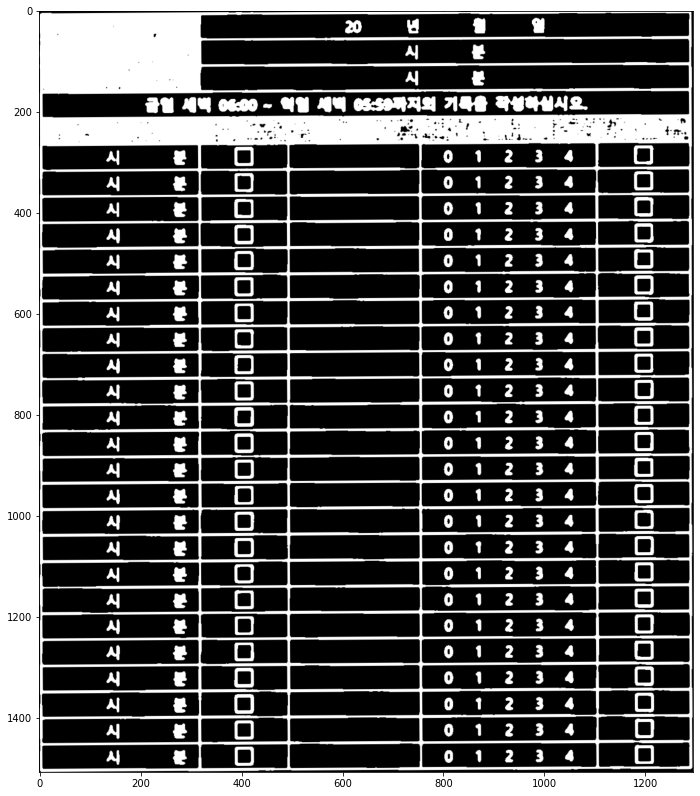

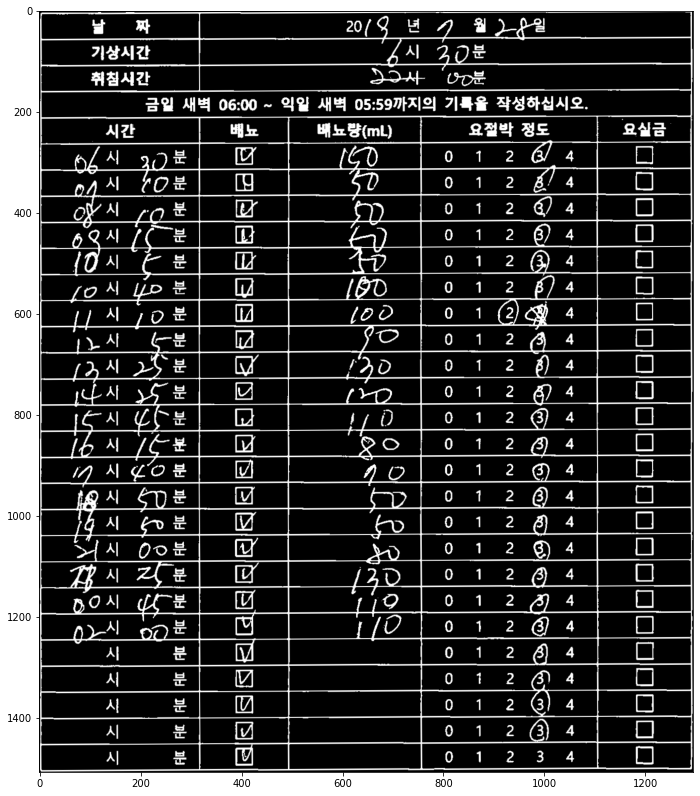

[[0, 1]]
[[0]]
[[0, 1]]
[[1, 2]]
[[0, 1]]
[[0, 4]]
[[0, 3]]
[[0, 1]]
[[0, 1, 2]]
[[2, 3]]
[[0, 1, 2, 3]]
[[0, 2]]
[[2, 5]]
[[0, 2]]
[[0, 1, 2]]
[[0, 2]]
[[1, 3, 5]]
[[0, 1, 2]]
[[0, 1, 2, 3]]
[[1, 2]]
[[0, 2]]
[[0, 1]]
[[1, 3]]
[[0, 2]]
[[1, 2]]
[[0, 1]]
[[0, 1, 2]]
[[1, 3, 4]]
[[0, 1, 2, 3]]
[[0, 1, 2]]
[[0, 3]]
[[1, 2]]
[[0, 1, 2]]
[[0, 1, 2, 3, 4]]
[[0, 1, 2]]
[[0]]
[[0, 1, 3]]
[[0, 1]]
[[0, 1]]
[[0, 1, 2, 3, 4]]
[[0, 1, 3]]
[[0, 1, 2, 3]]
[[0, 2, 5, 6]]
[[0], [2]]
[[0, 2, 3, 4]]
[[3], [0, 1]]
[[0, 8]]
[[0]]
[[0]]
[[2, 6]]
[[0, 2]]
[[0, 1]]
[[0, 2, 3]]
[[0, 3]]
[[0, 4]]
[[0]]
[[0]]
[[4], [0, 1, 2]]
[[1, 5, 7]]
[[0]]
[[0, 1], [3, 6, 7]]
[[0, 1]]
[[0, 1, 2, 3, 4]]
[[5], [1, 2, 3]]
[[0]]


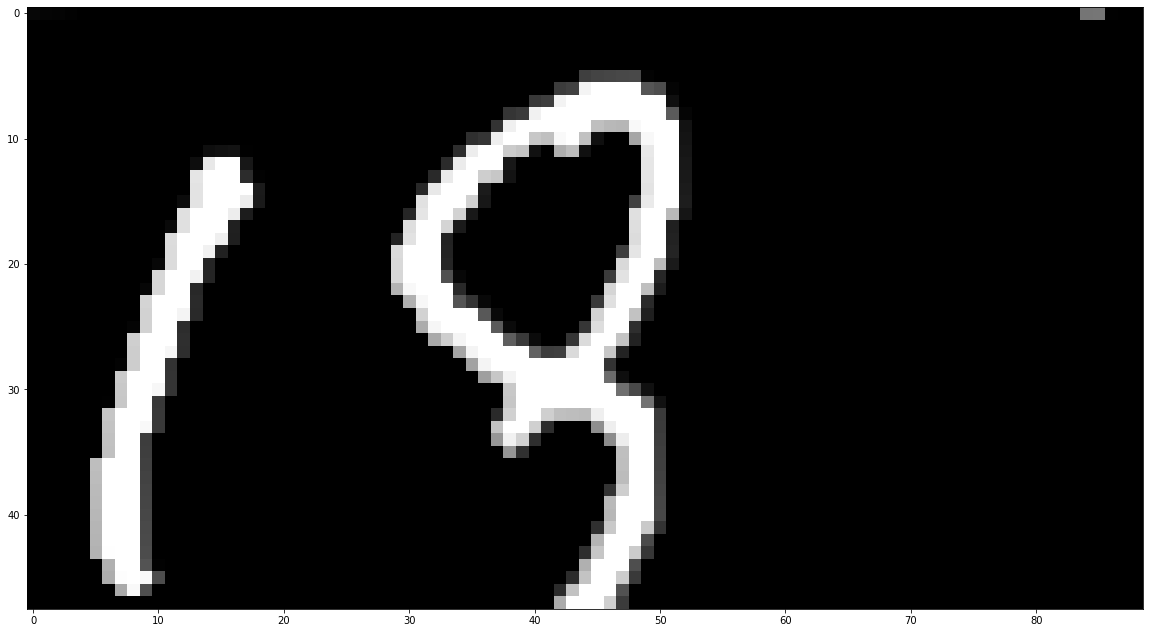

[[0, 1]]
18


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:288: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


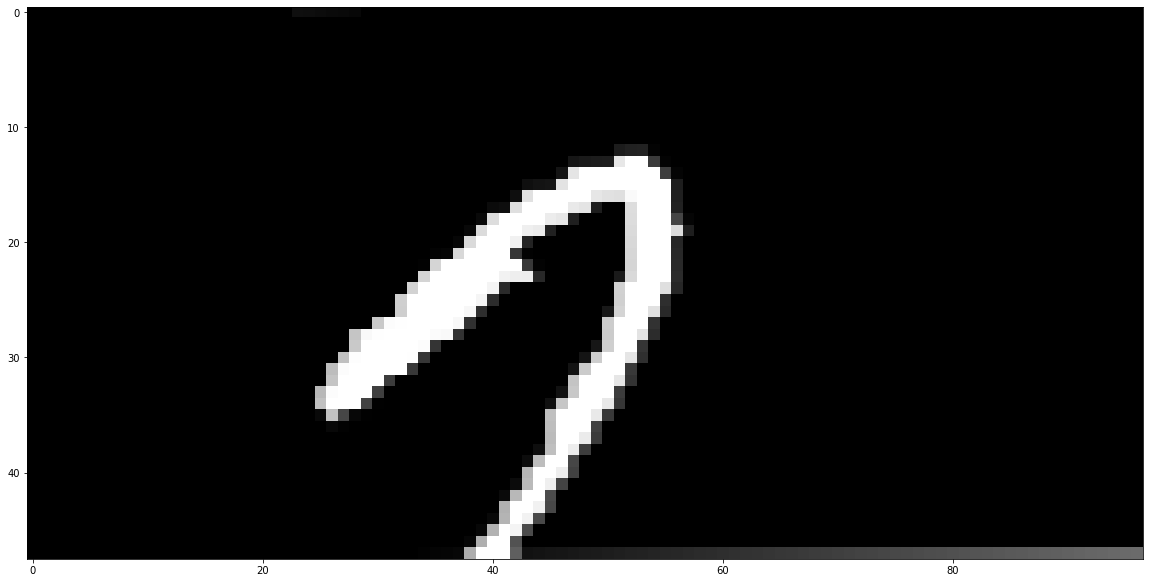

[[0]]
77


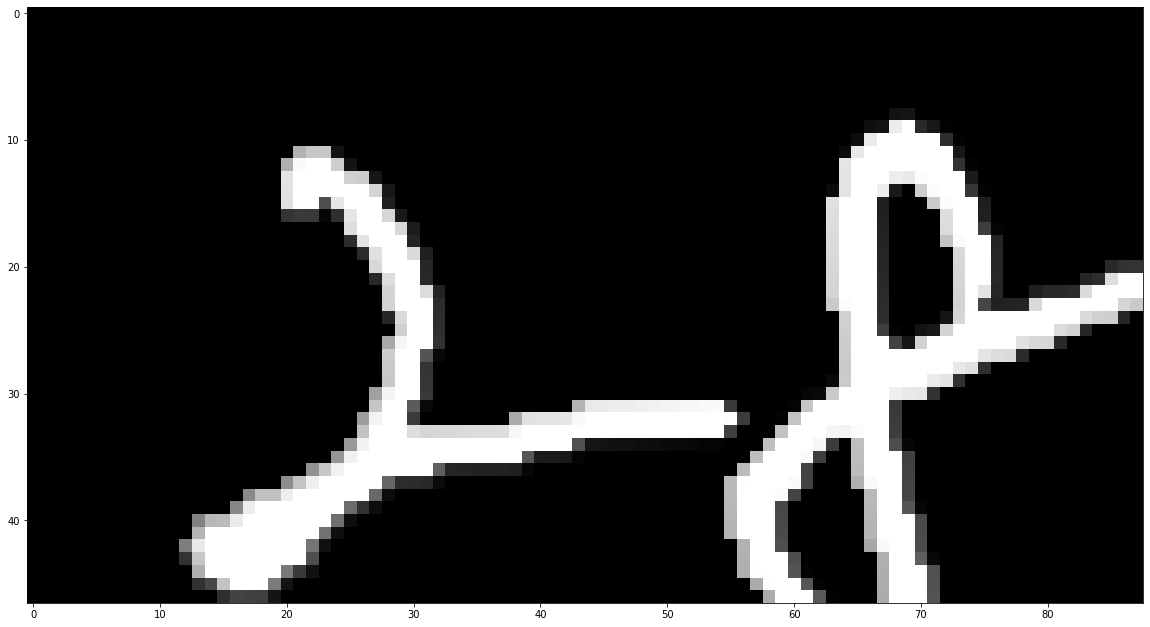

[[0, 1]]
28


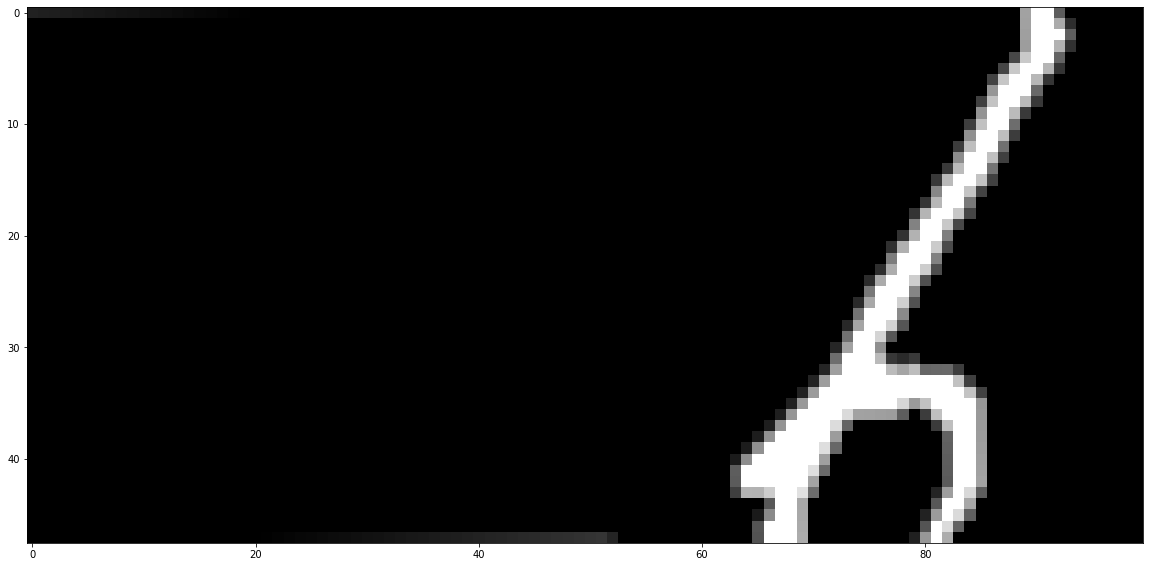

[[1]]
1


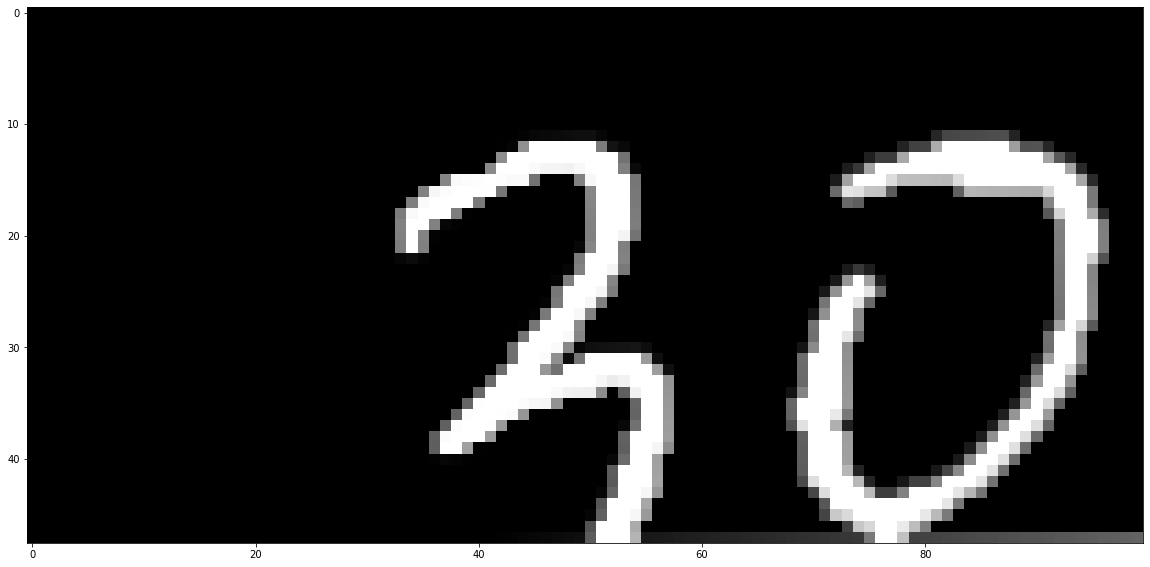

[[0]]
30


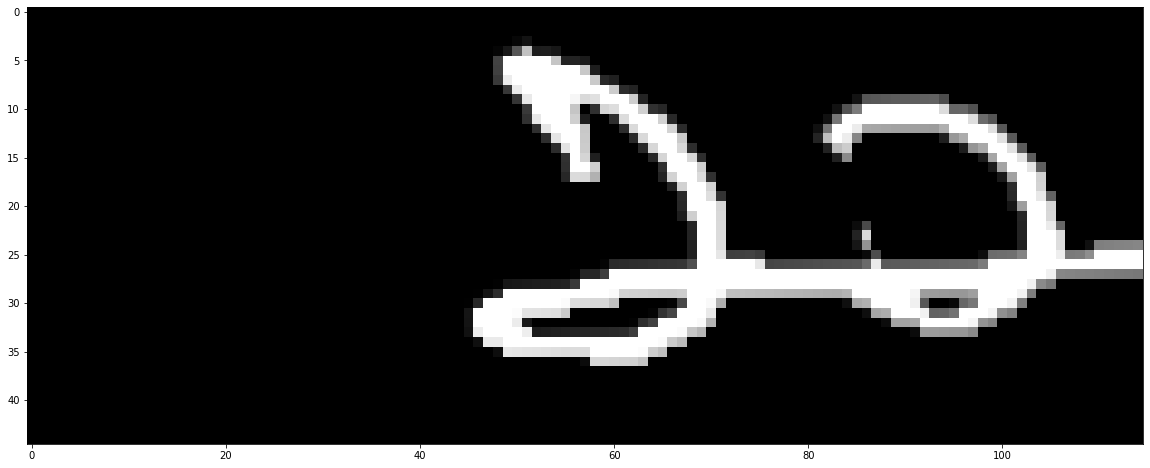

[[0]]
22


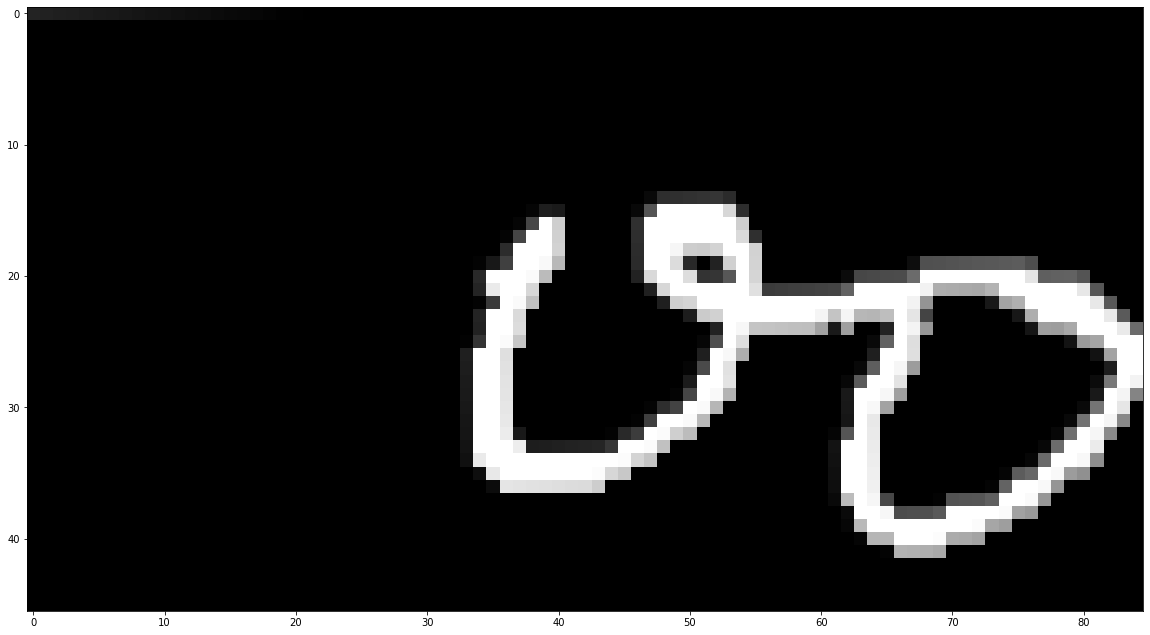

[[0]]
00


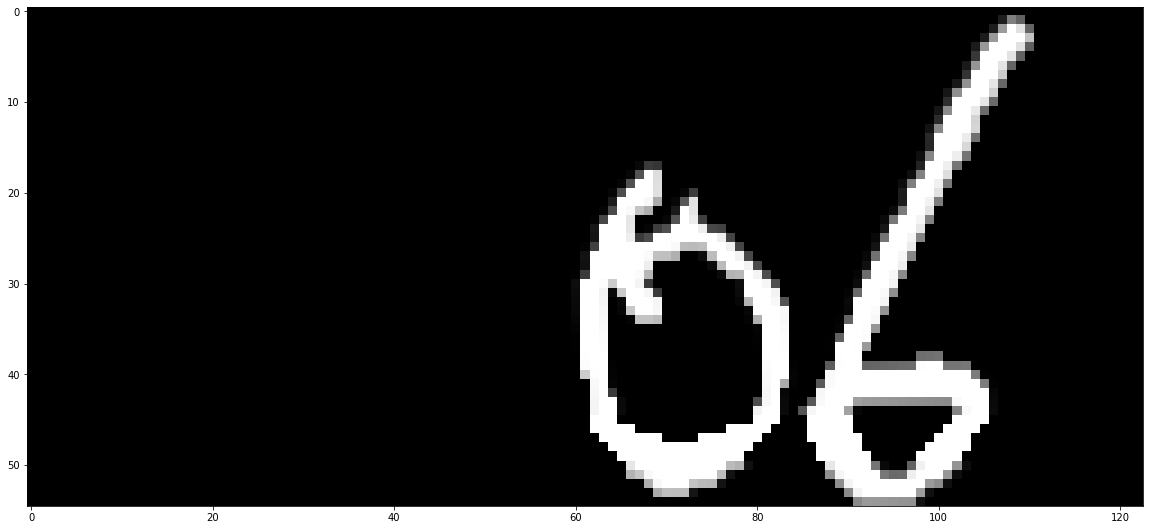

[[0, 2]]
06


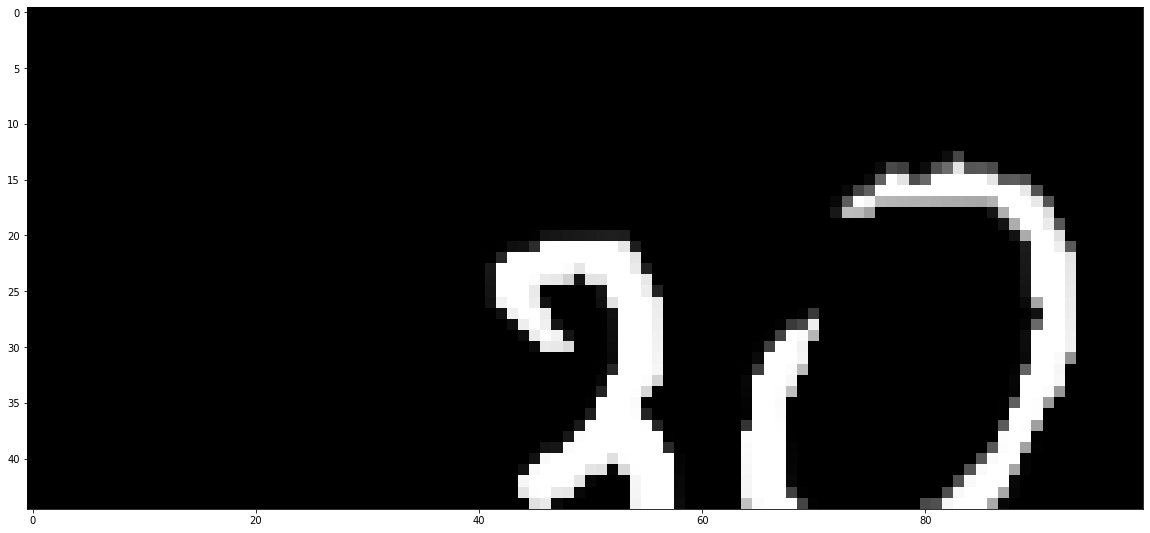

[[0, 1, 2]]
217


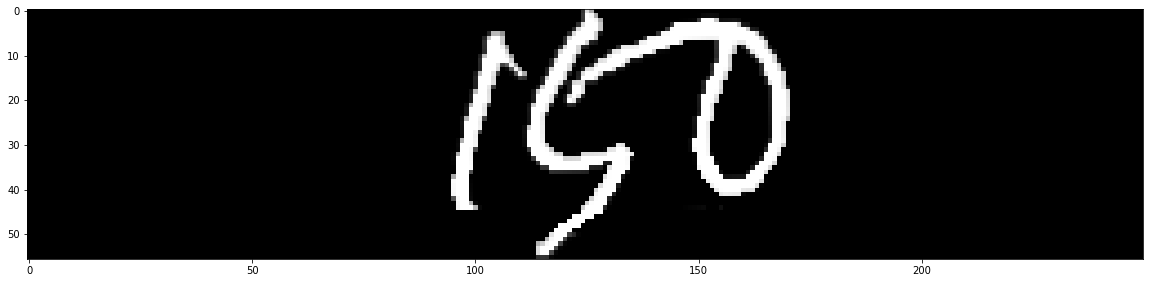

[[2, 3]]
150


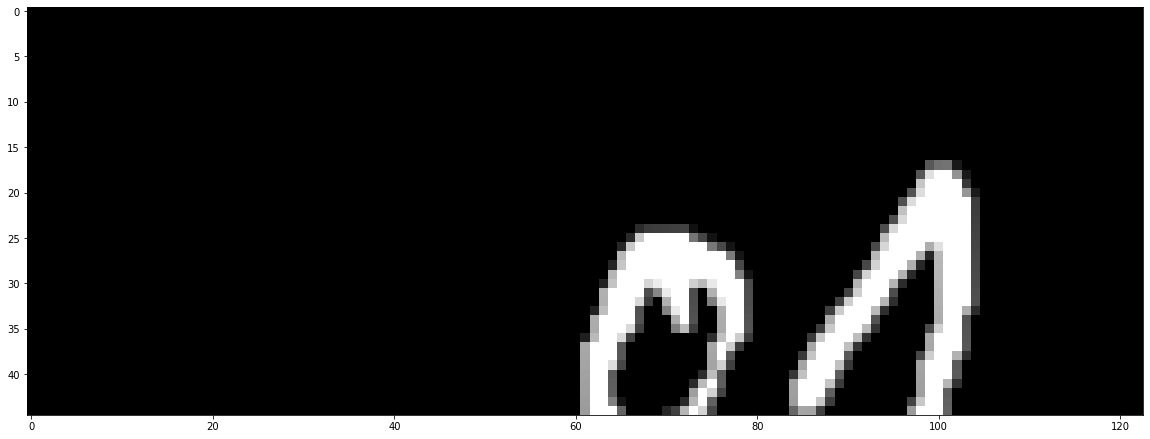

[[0, 1]]
1711


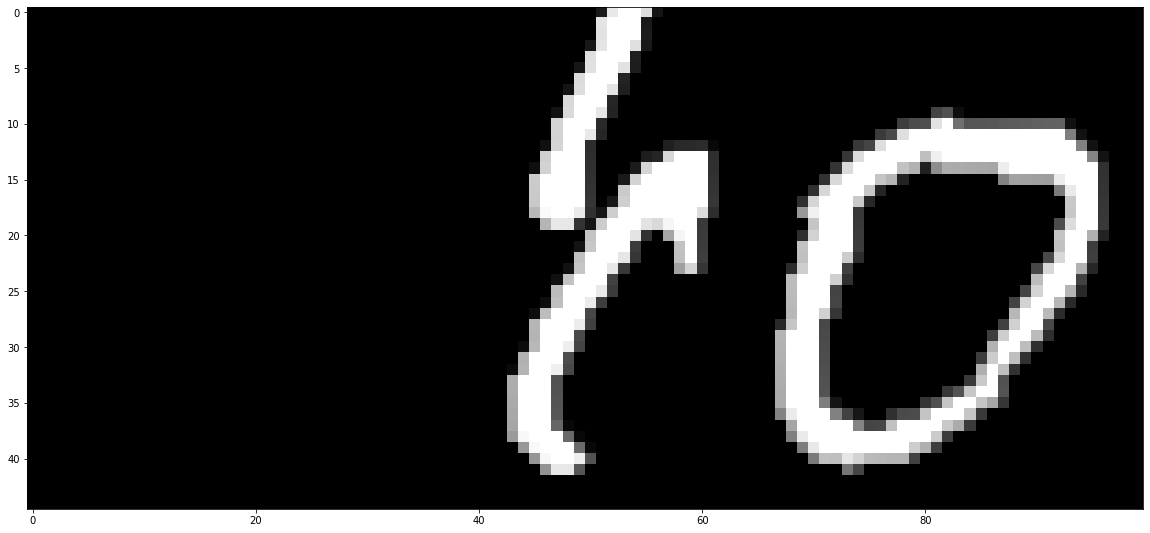

[[0, 2]]
10


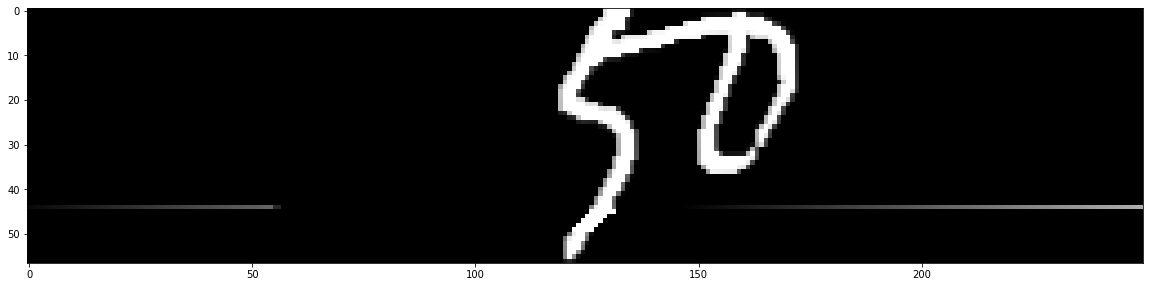

[[2]]
50


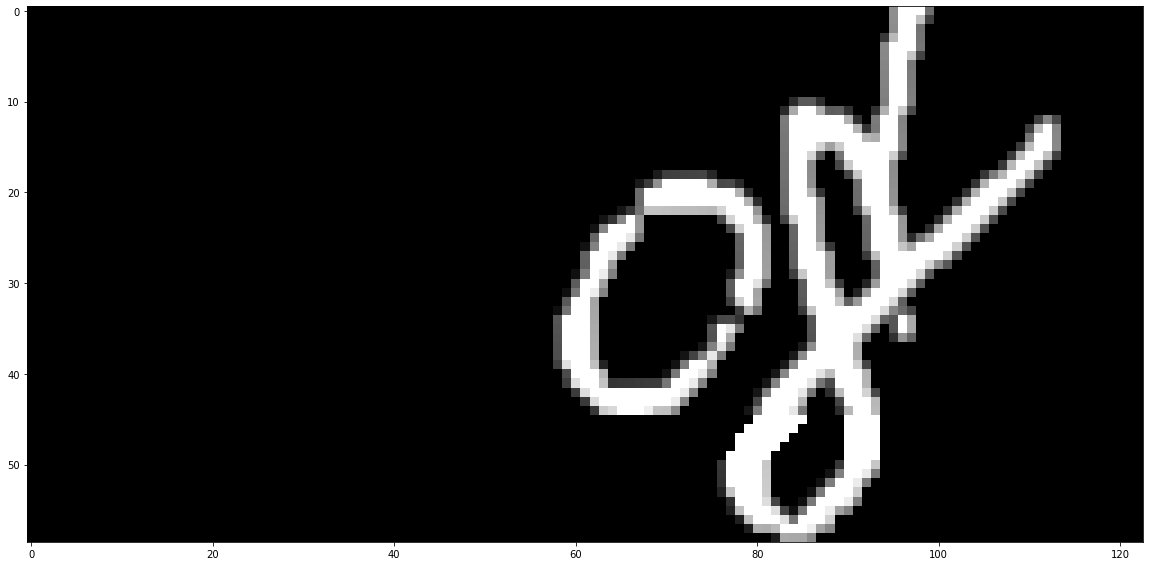

[[0, 2]]
08


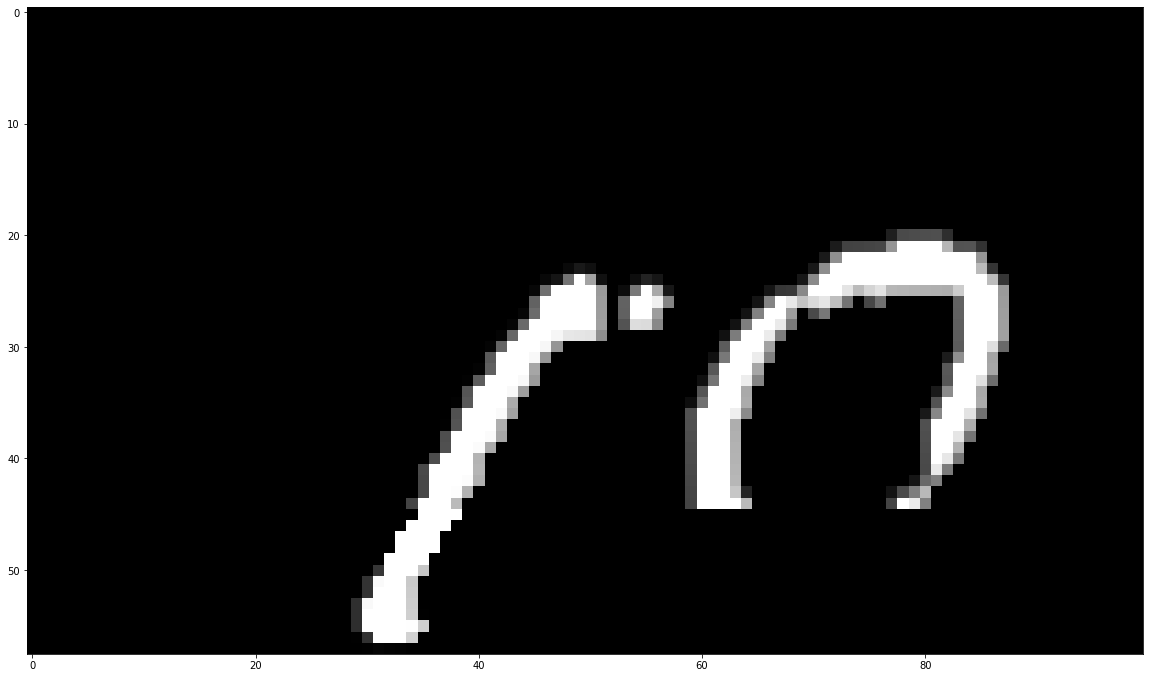

[[1, 2]]
117


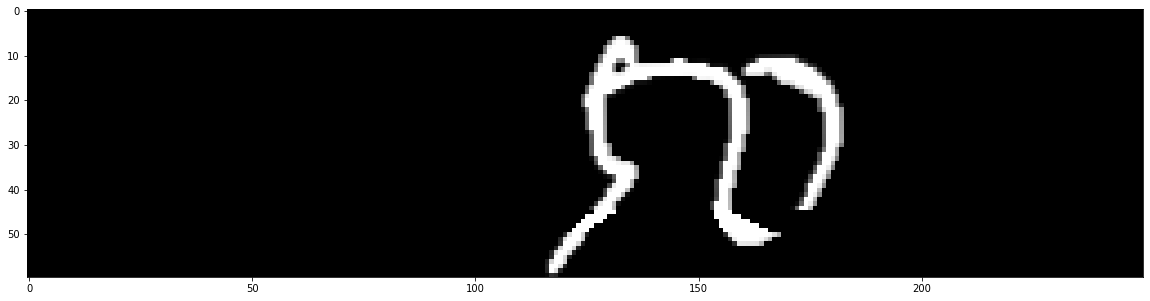

[[0]]
50


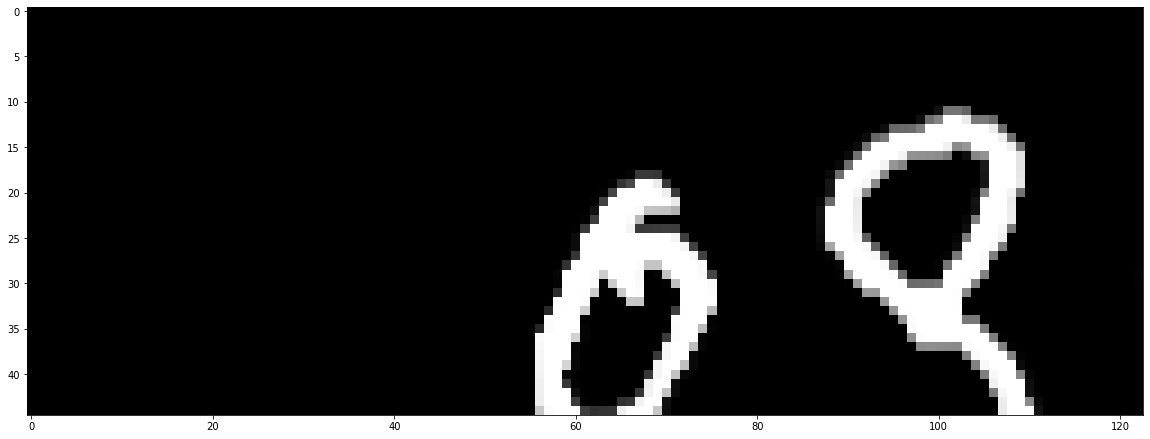

[[1, 3]]
09


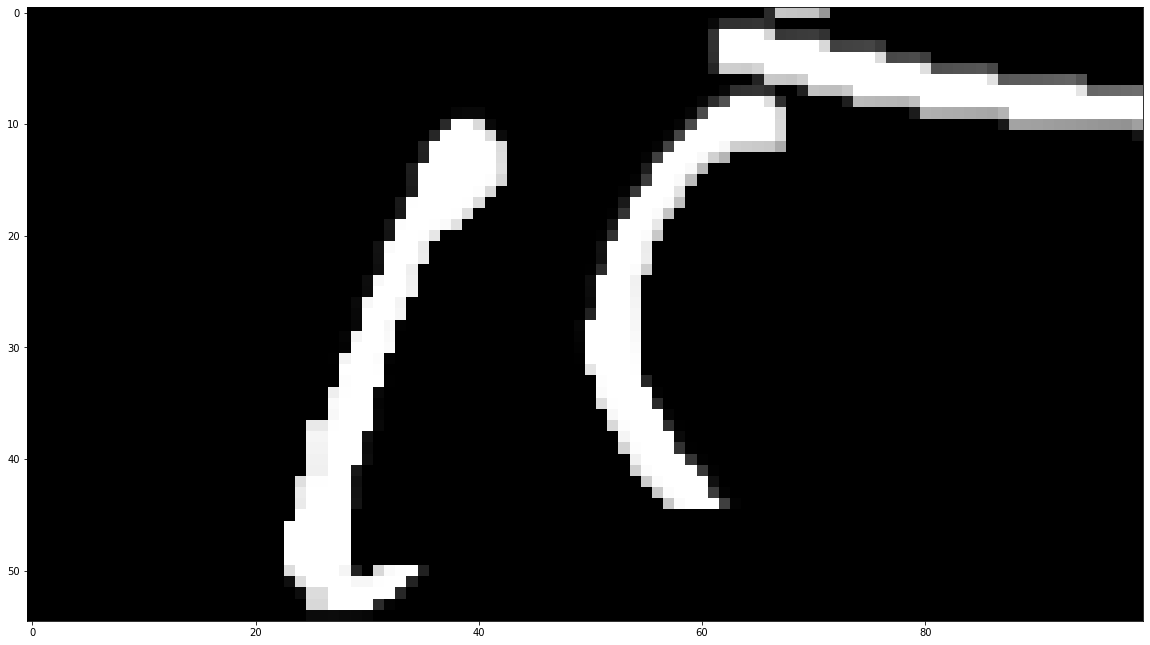

[[0, 1]]
10


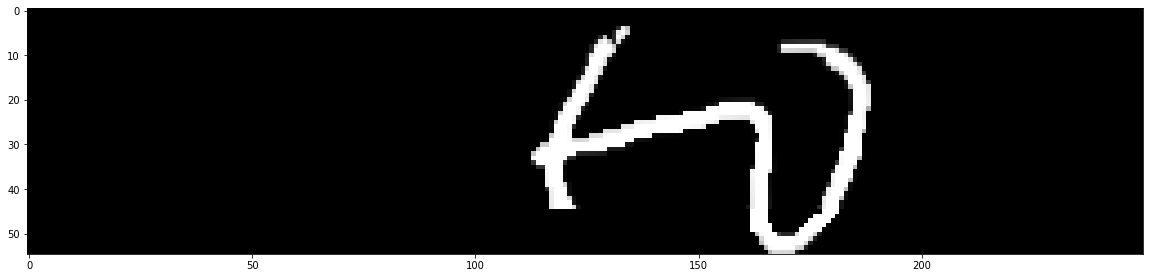

[[0]]
40


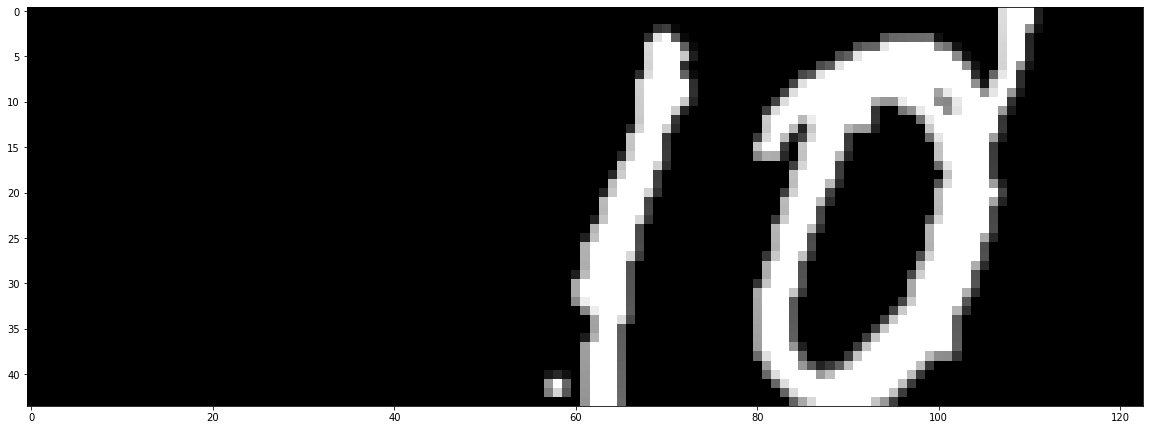

[[1, 2]]
10


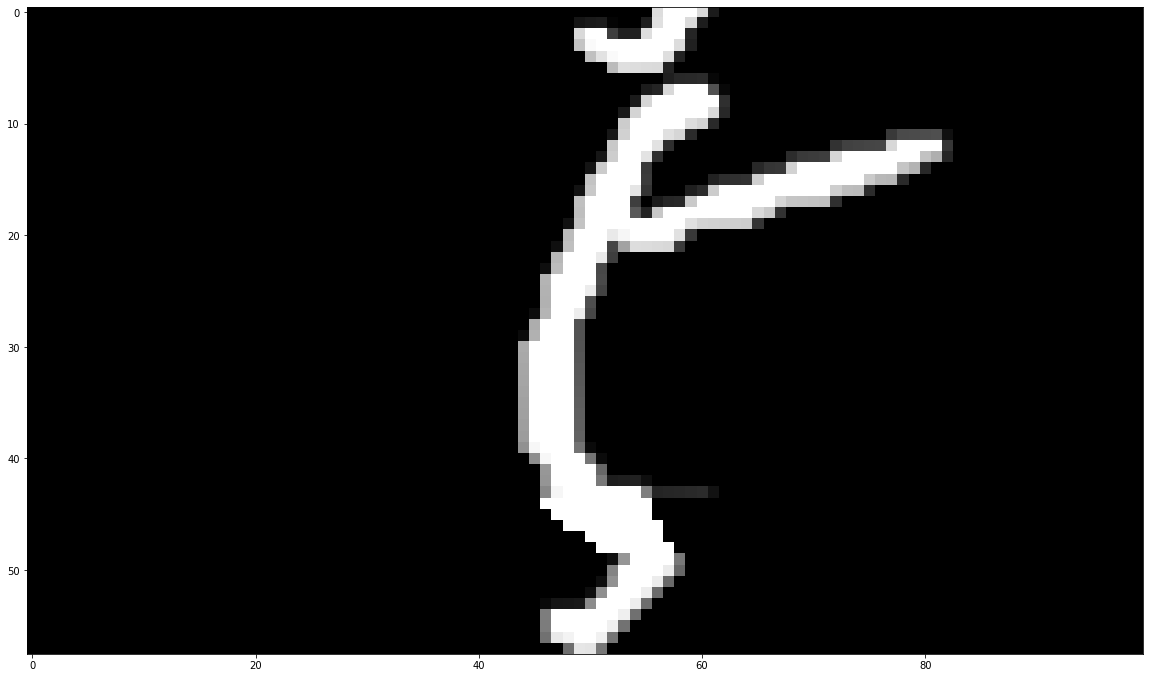

[[0]]
5


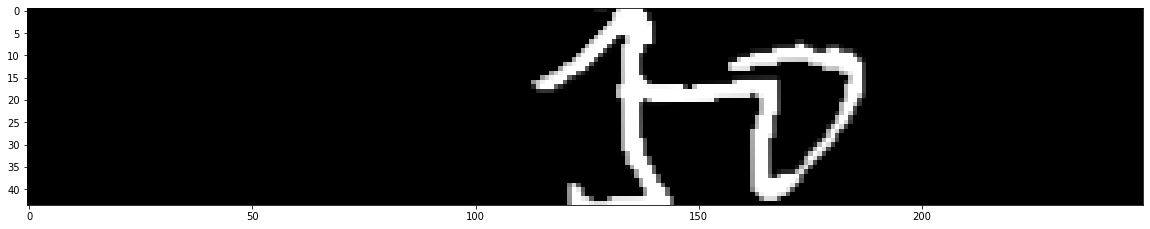

[[0]]
70


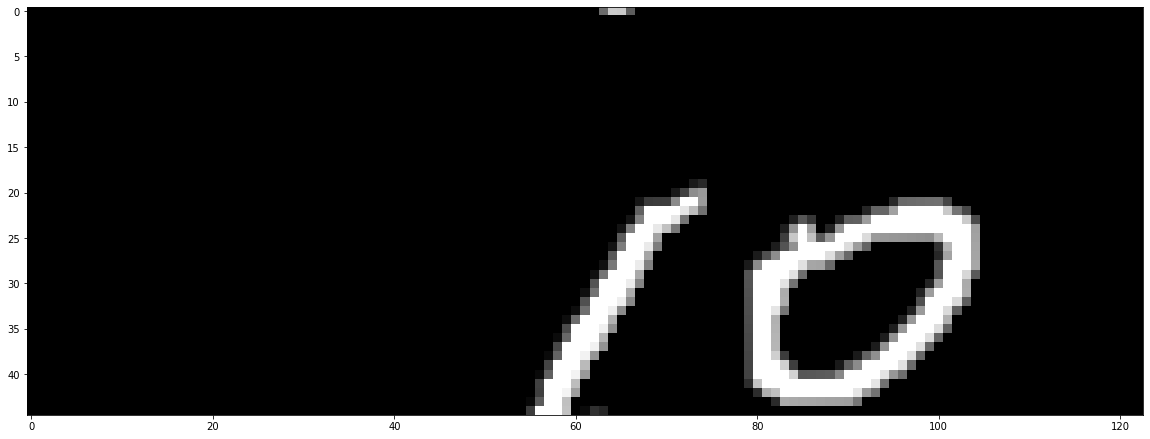

[[1, 3]]
10


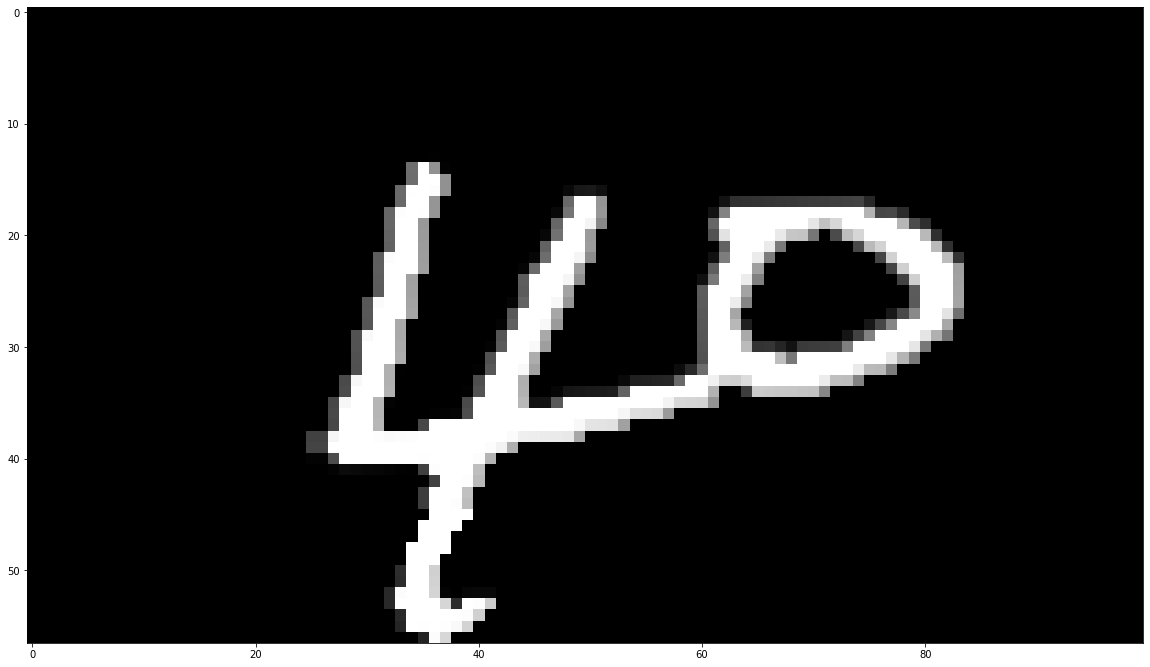

[[0]]
40


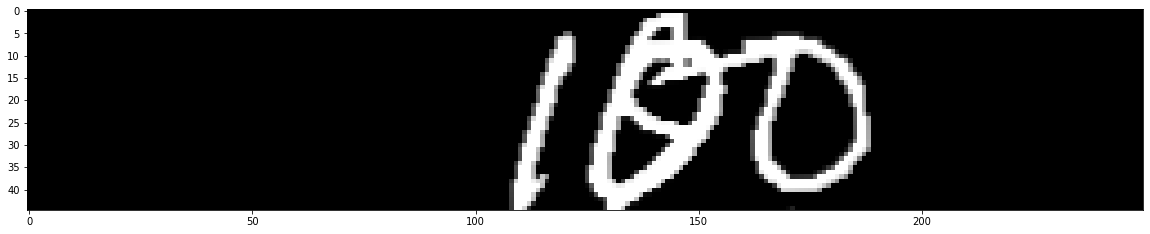

[[1, 2]]
190


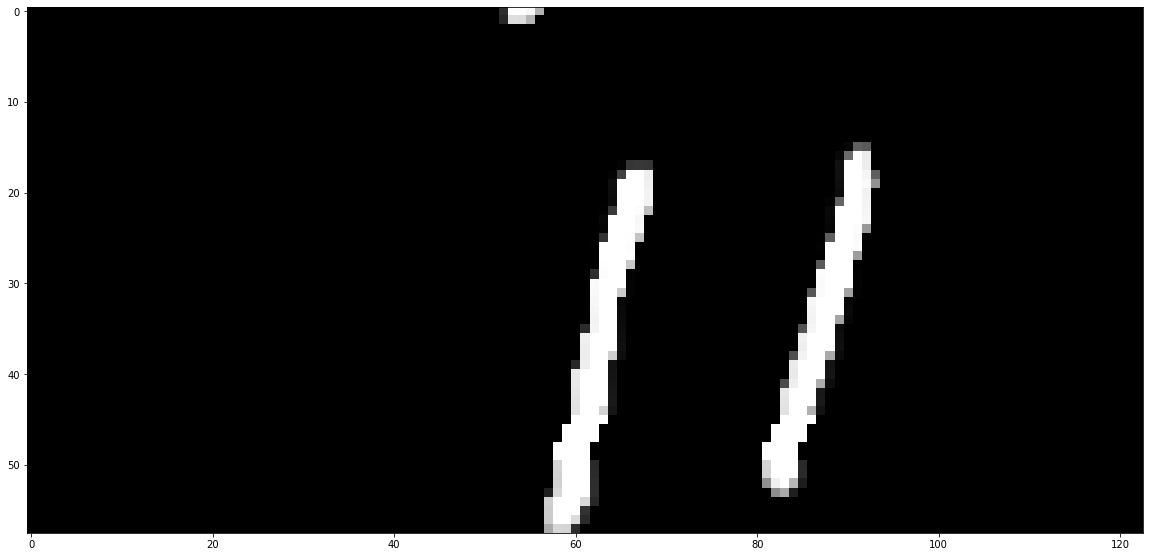

[[0, 1]]
11


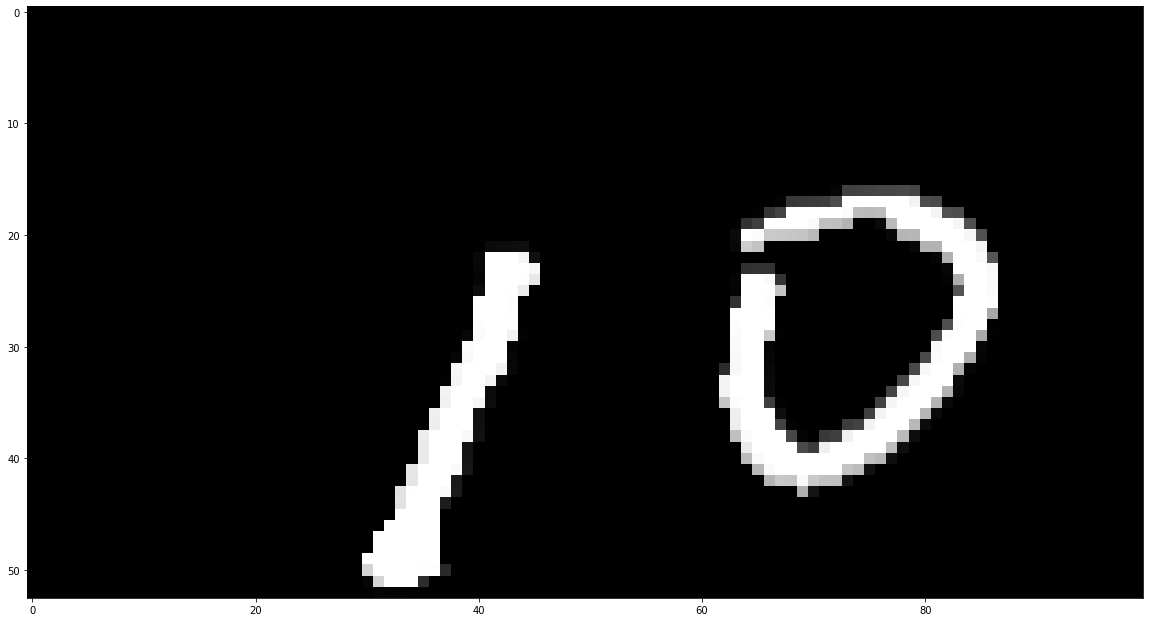

[[0, 1]]
10


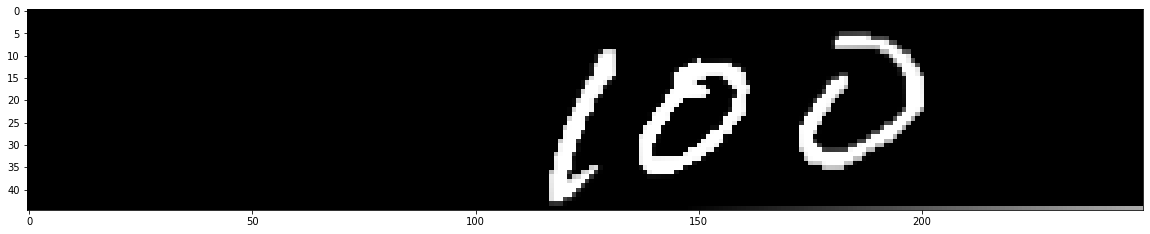

[[1, 3, 4]]
100


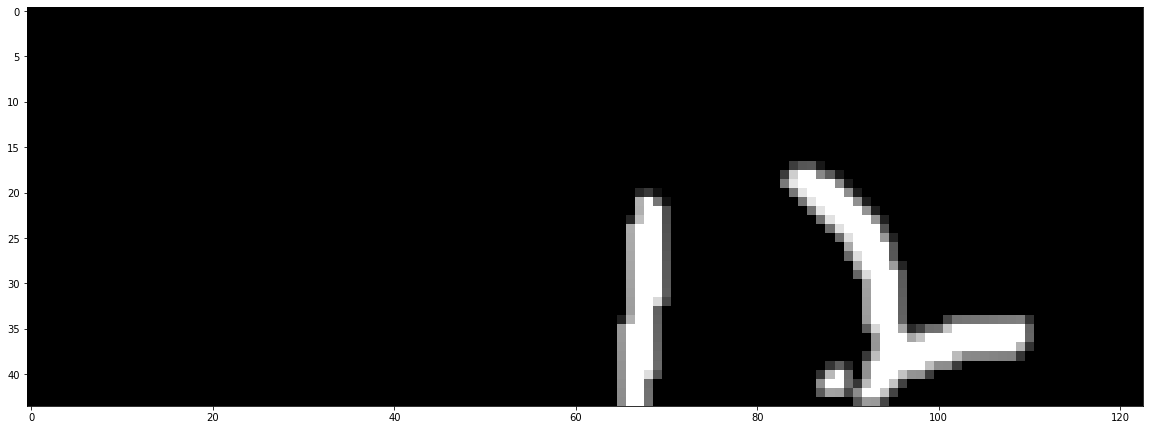

[[0, 1]]
12


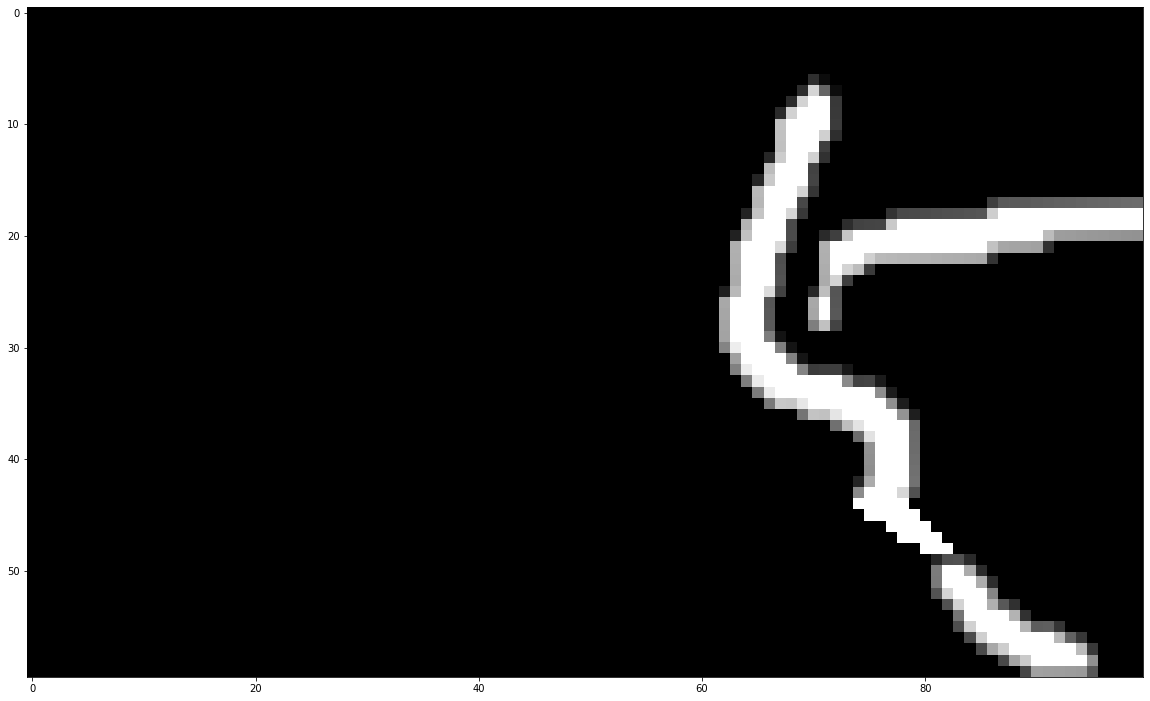

[[0, 1]]
44


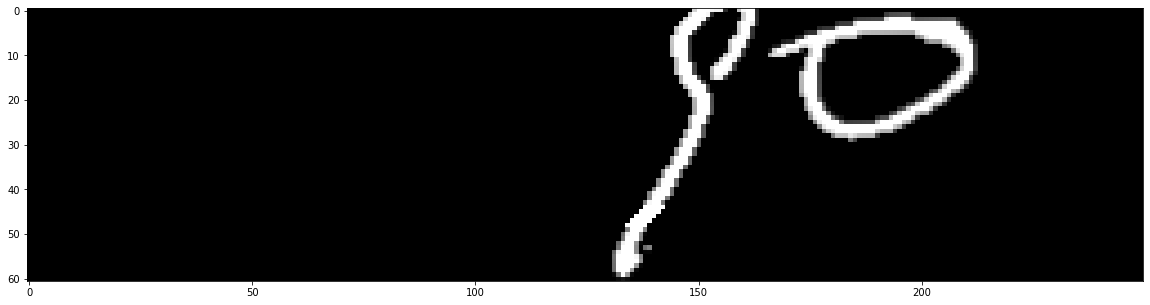

[[0, 3]]
90


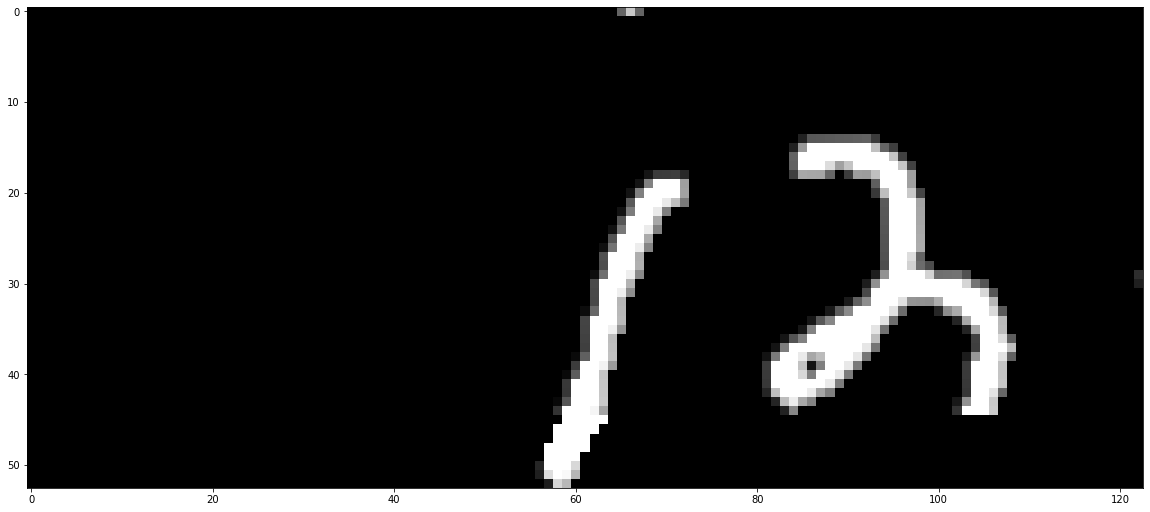

[[1, 2]]
12


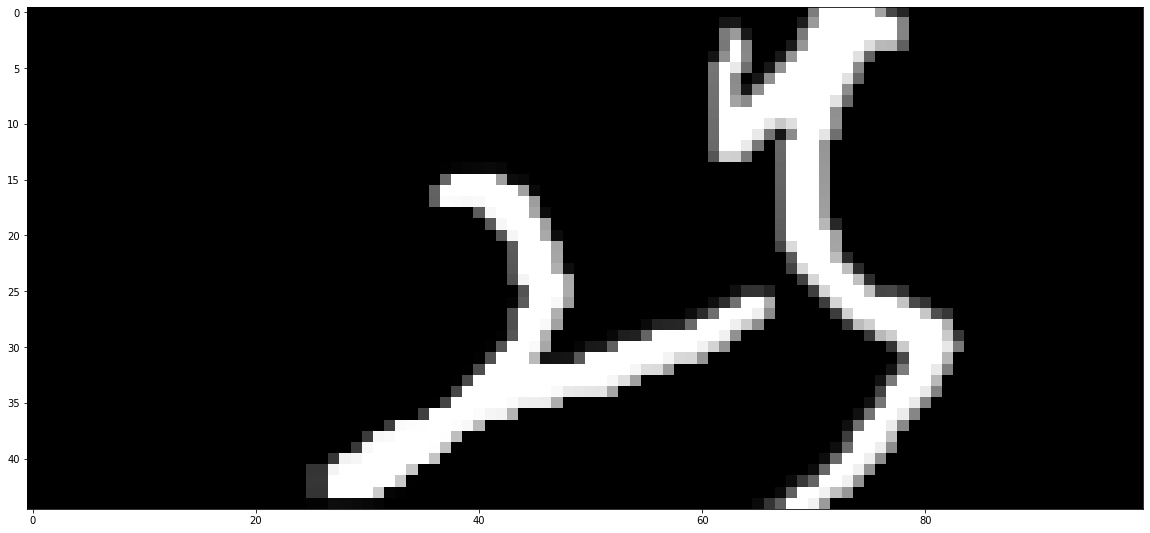

[[0, 1]]
25


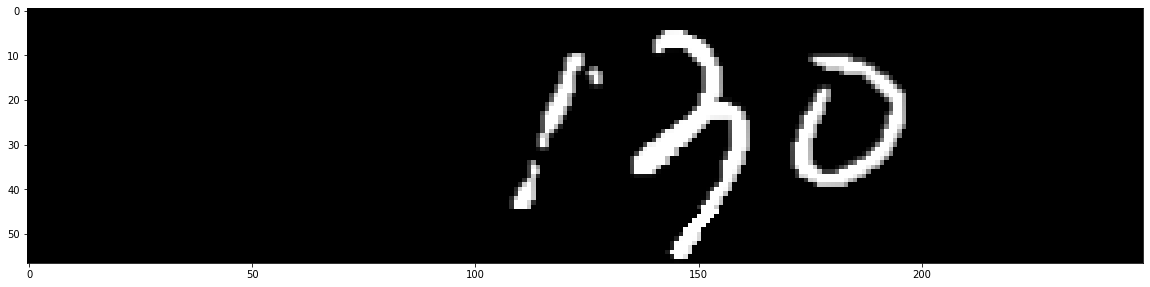

[[1], [3]]
3


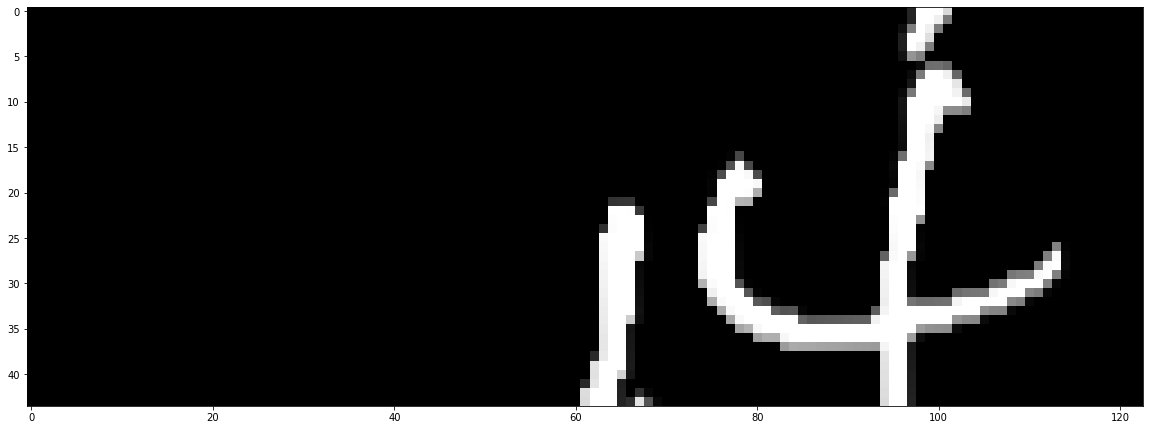

[[0, 1]]
14


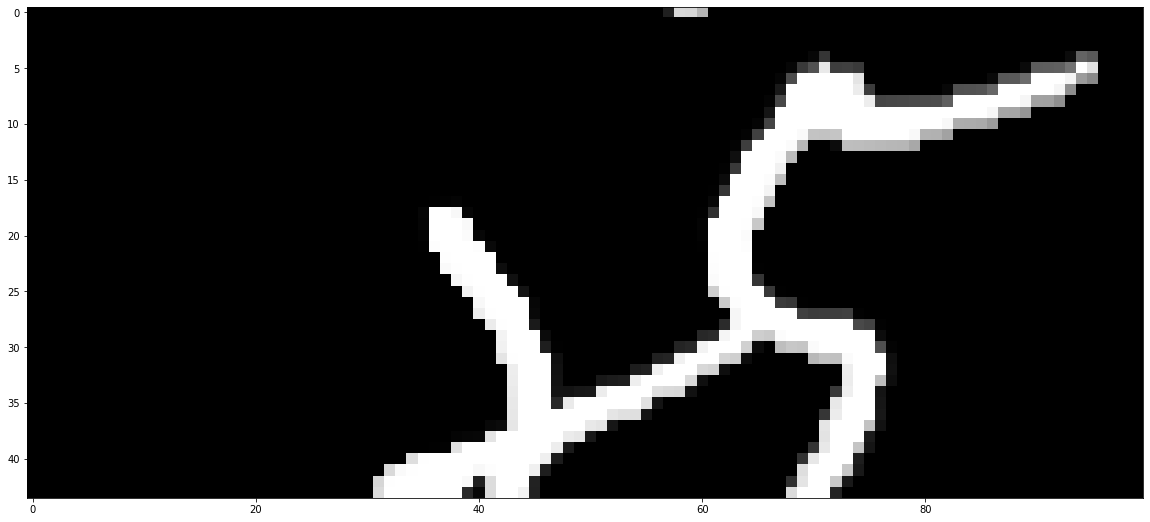

[[0]]
15


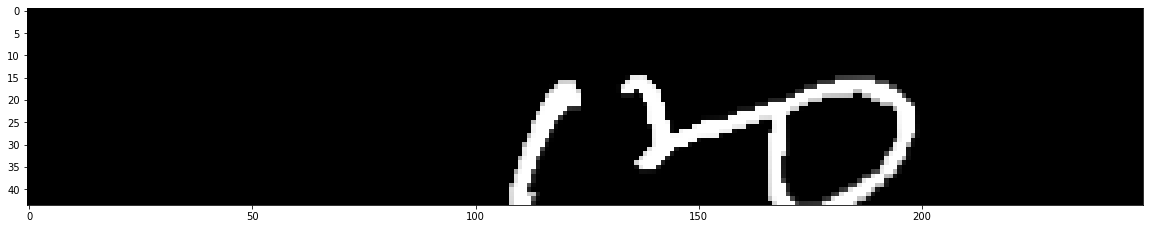

[[0, 1]]
143


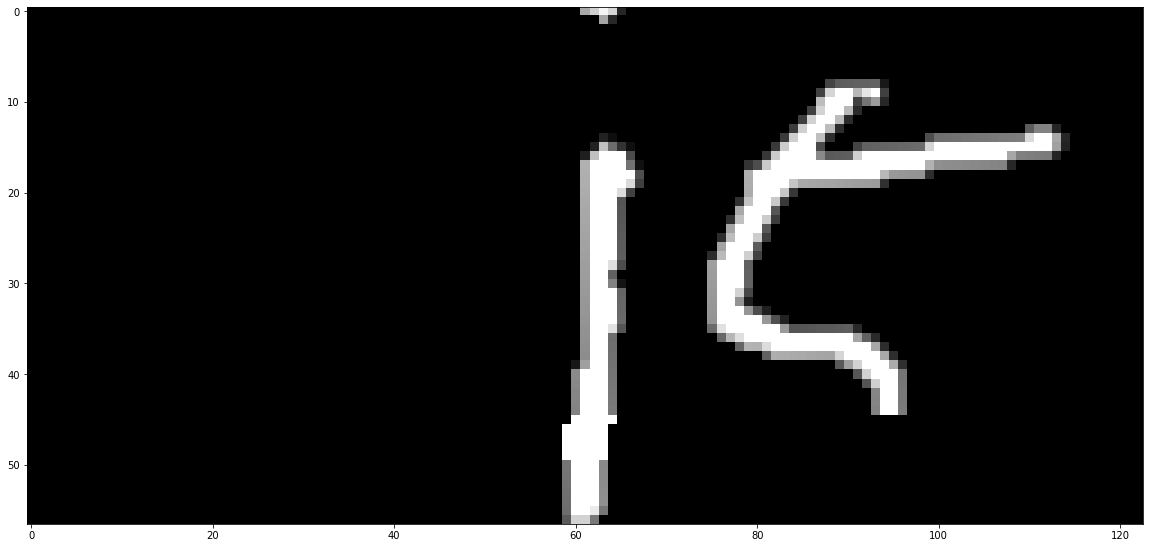

[[0, 1]]
15


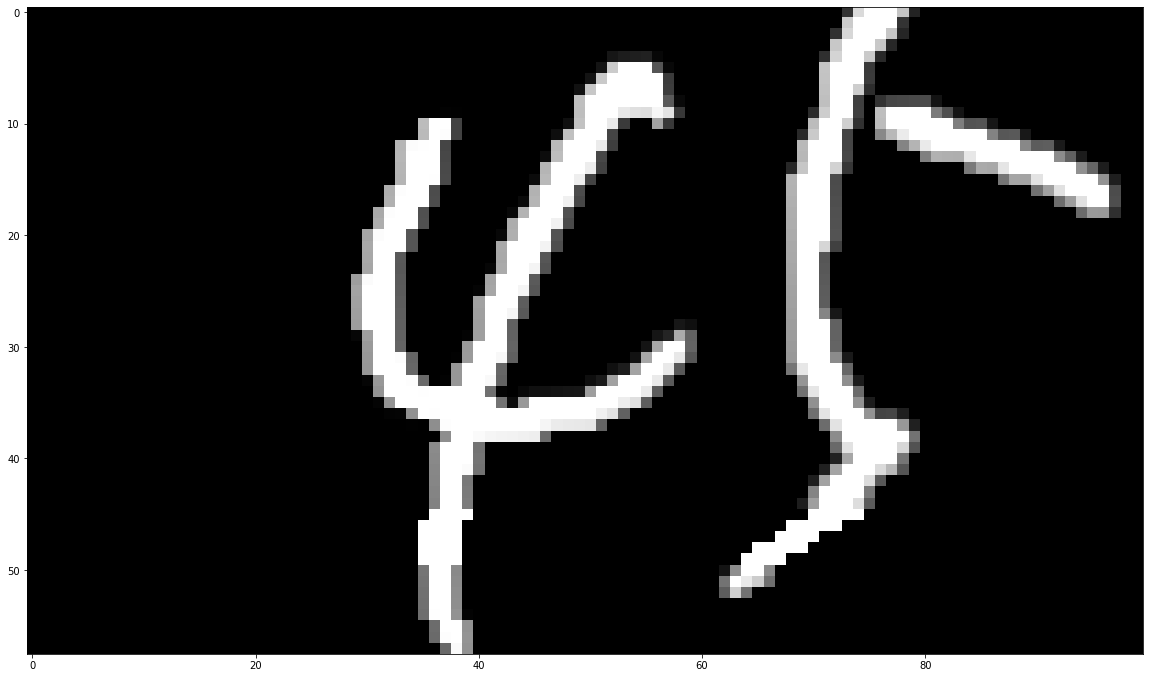

[[0, 1]]
45


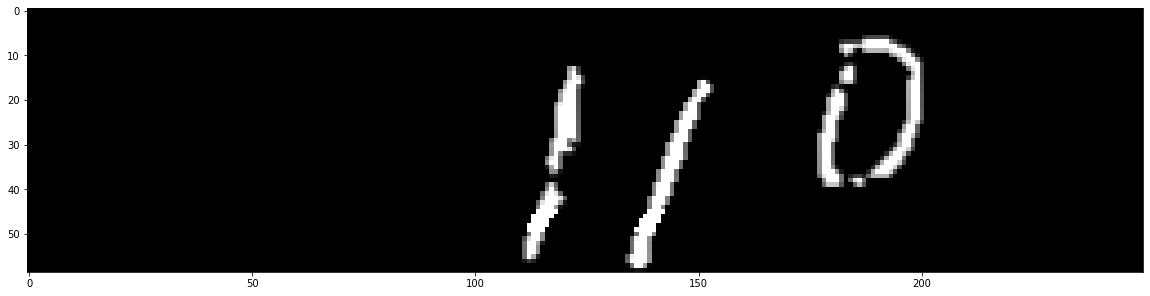

[[1], [4]]
7


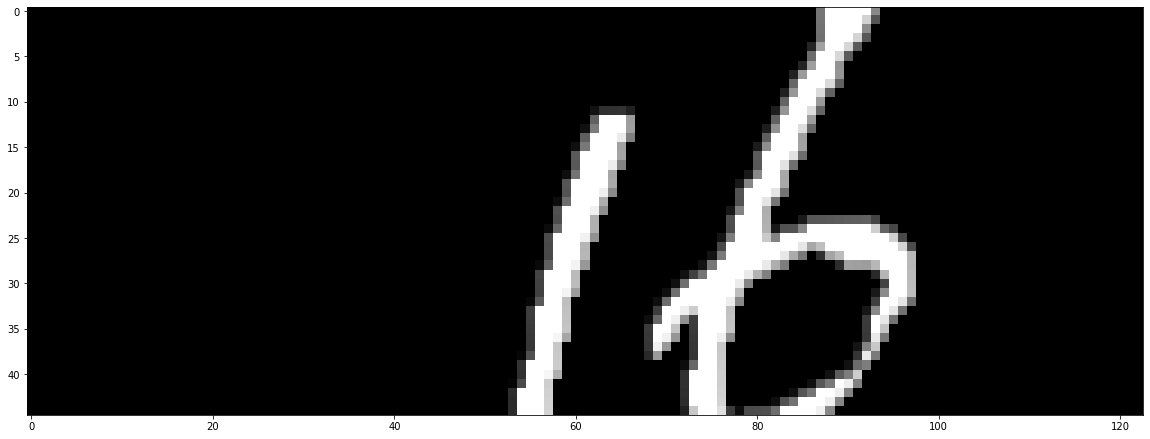

[[0, 1]]
16


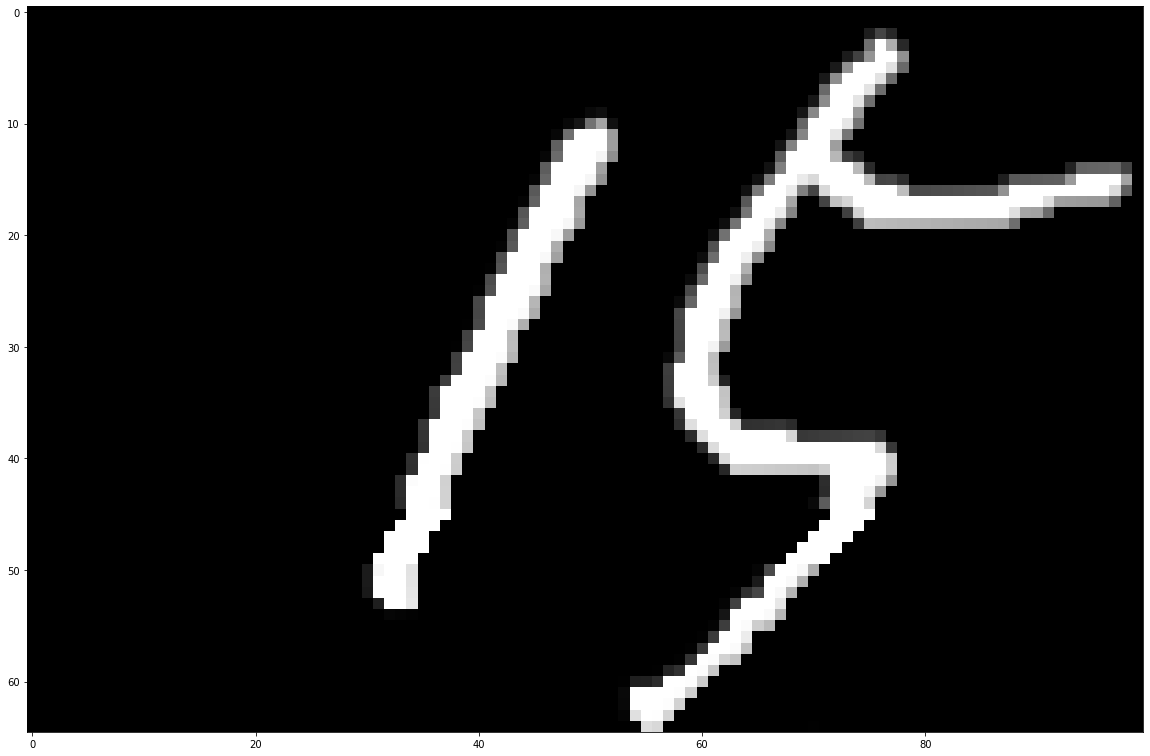

[[1, 2]]
15


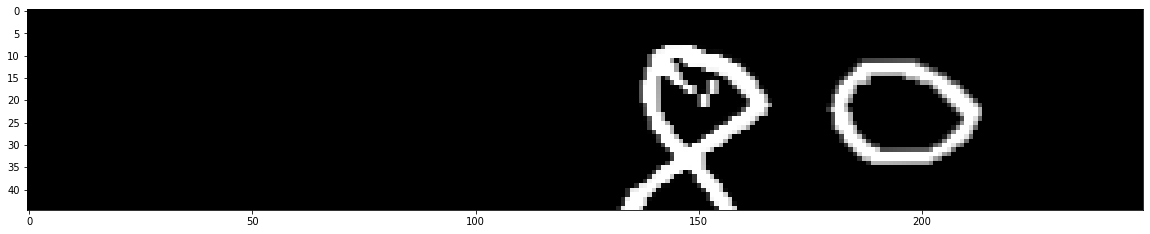

[[0, 2]]
80


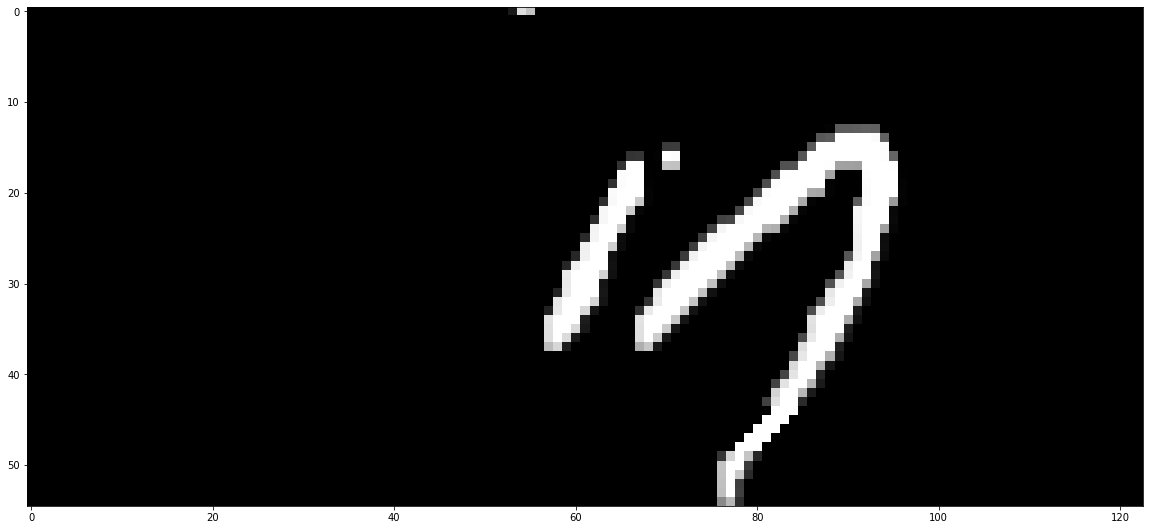

[[0], [2]]
7


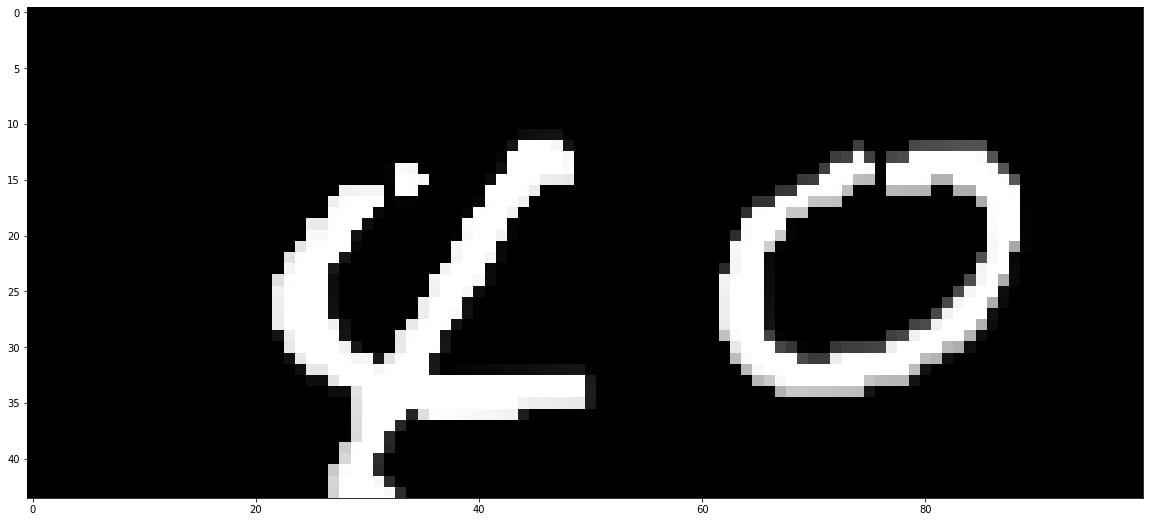

[[0, 2]]
40


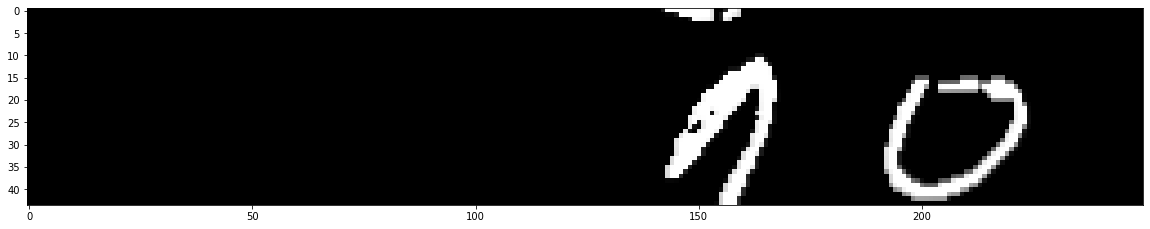

[[0, 1]]
90


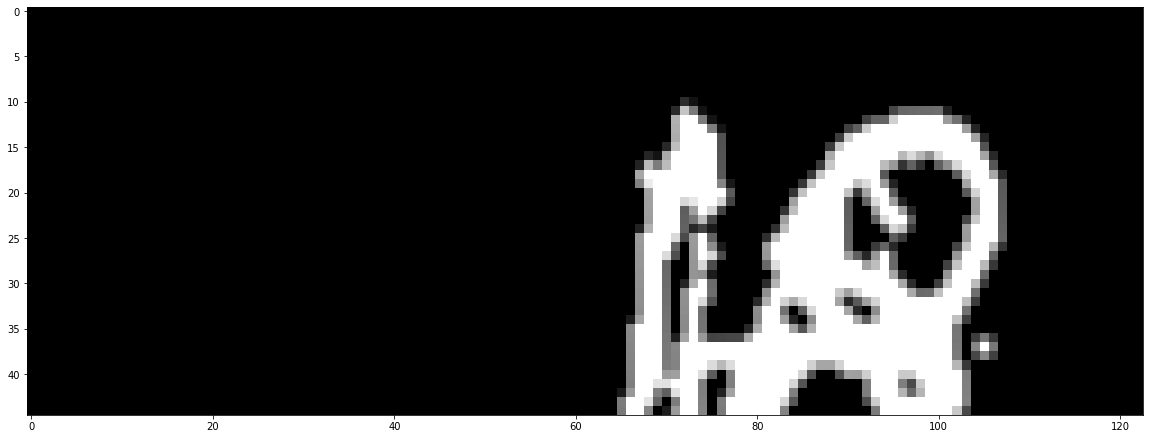

[[0]]
12


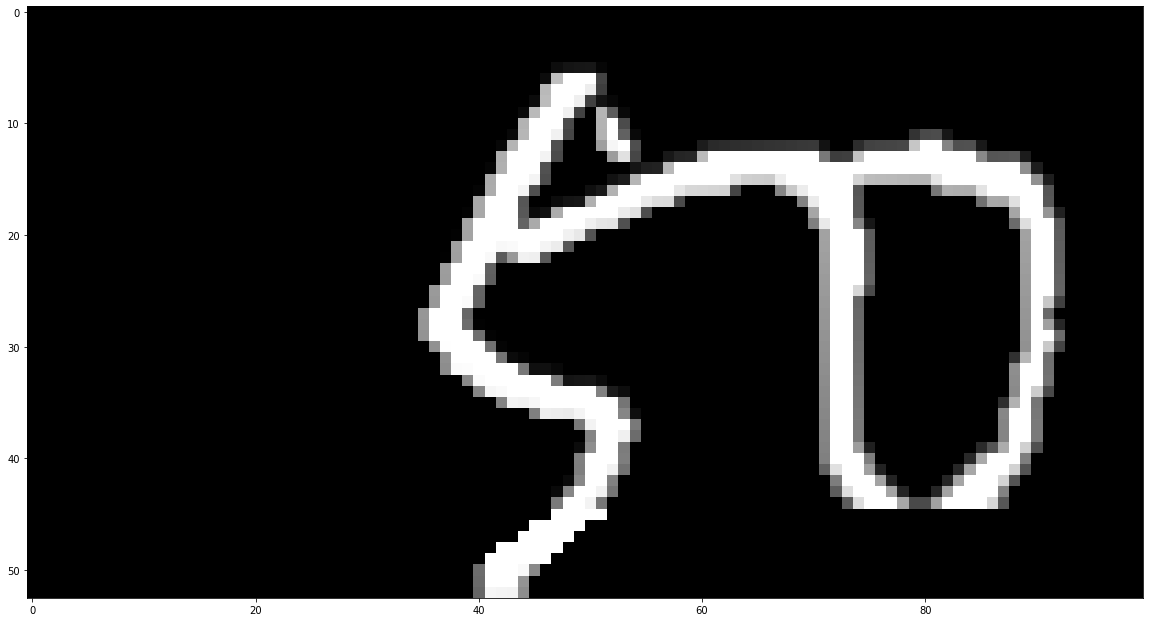

[[0]]
50


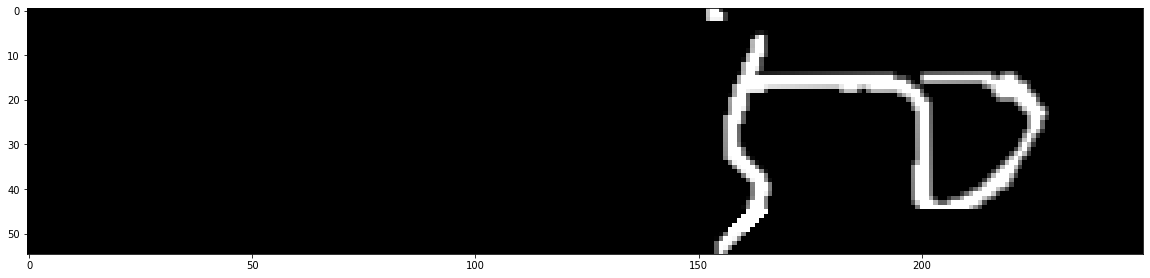

[[0]]
50


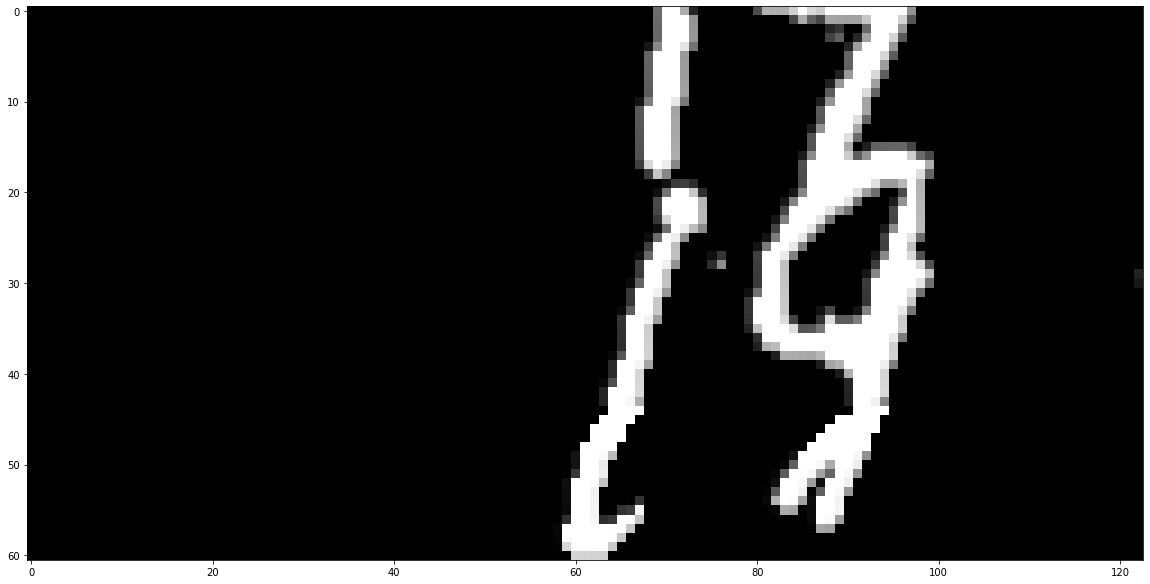

[[2, 6]]
15


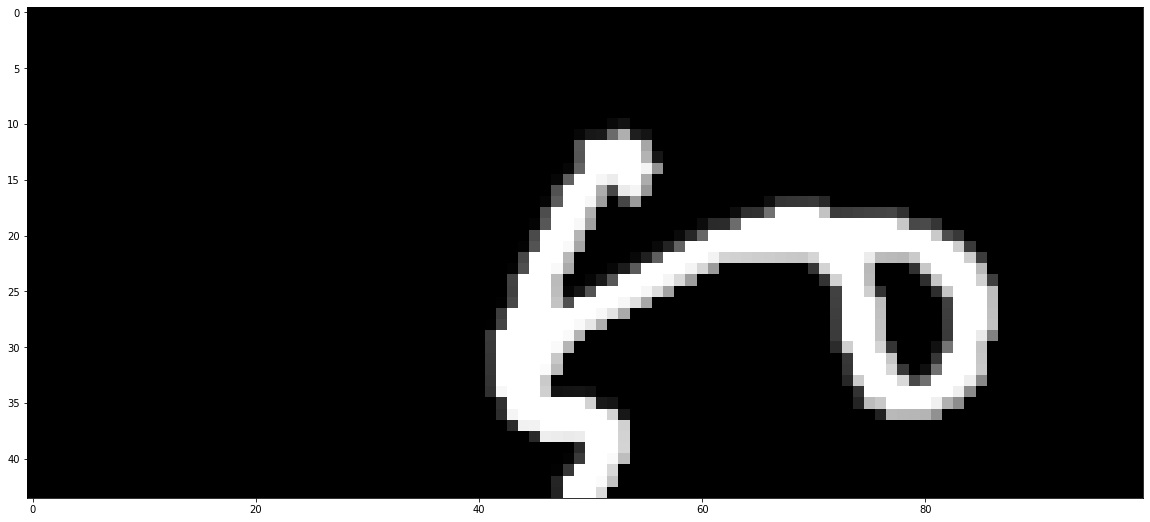

[[0]]
80


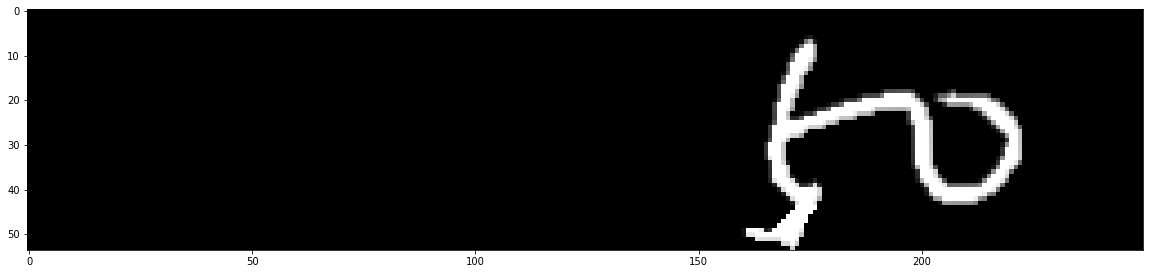

[[0]]
50


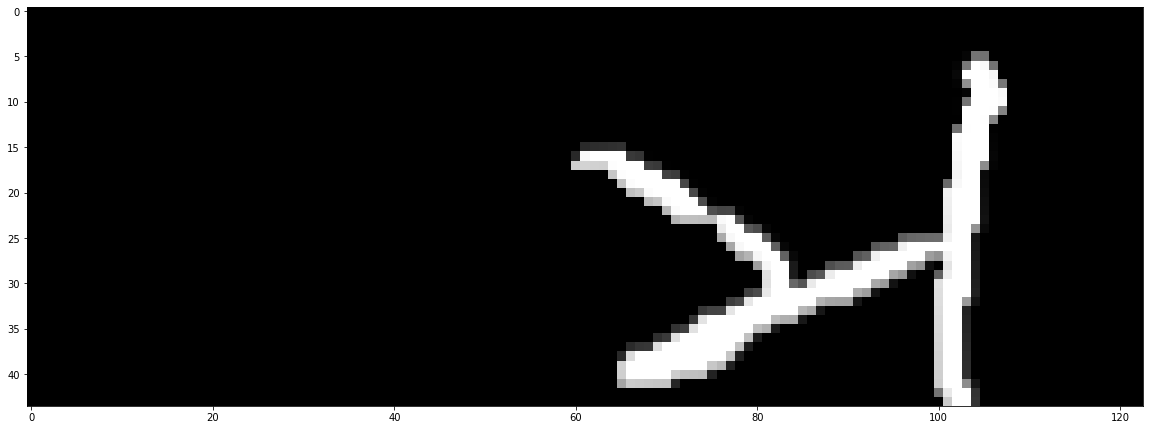

[[0]]
34


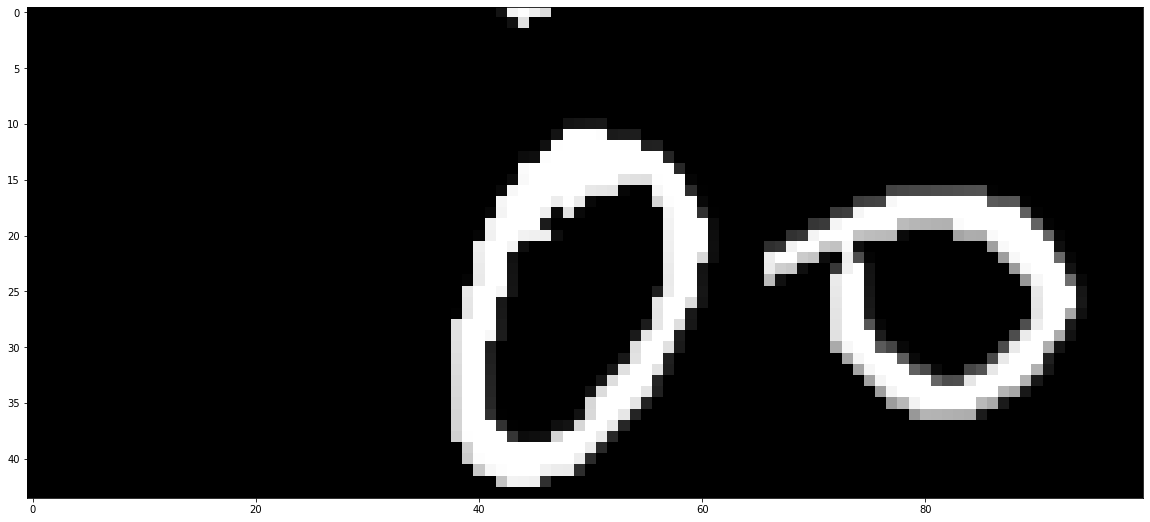

[[0, 3]]
00


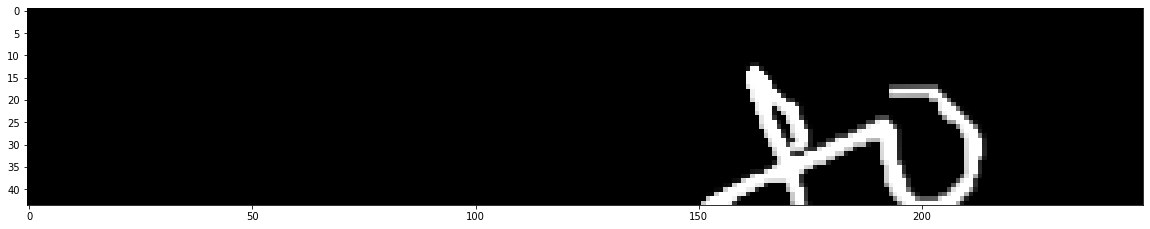

[[0]]
40


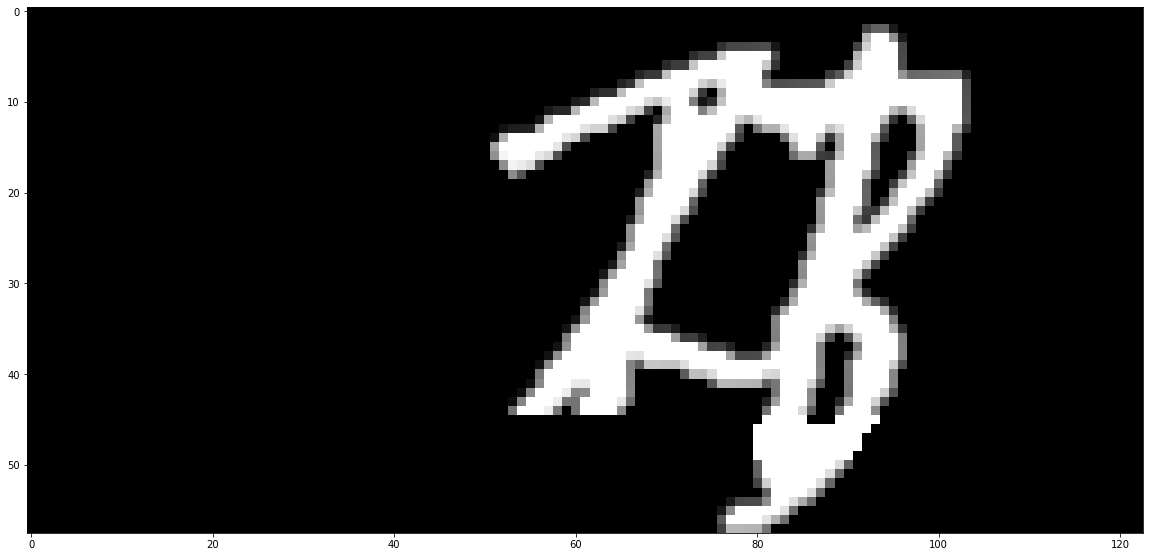

[[0]]
23


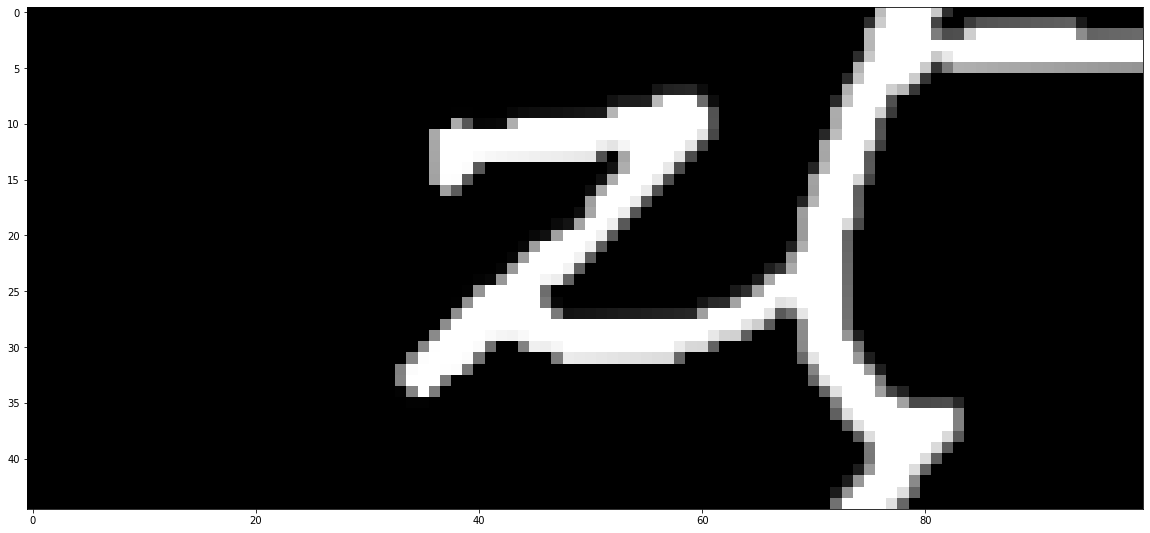

[[0]]
25


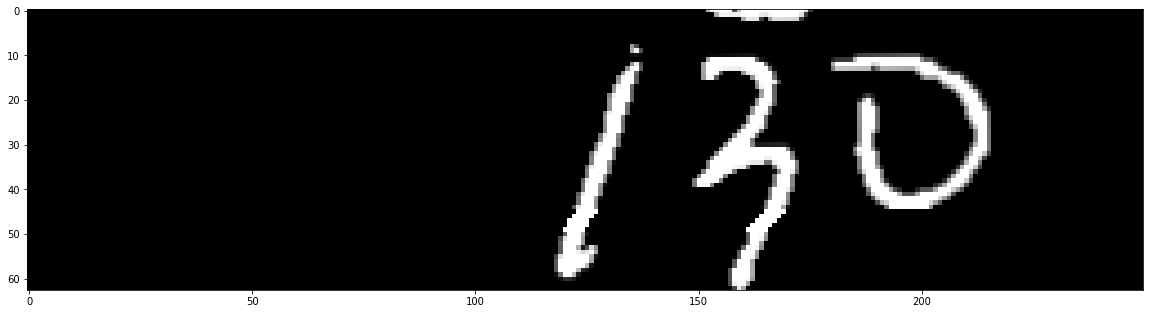

[[0, 1, 2]]
130


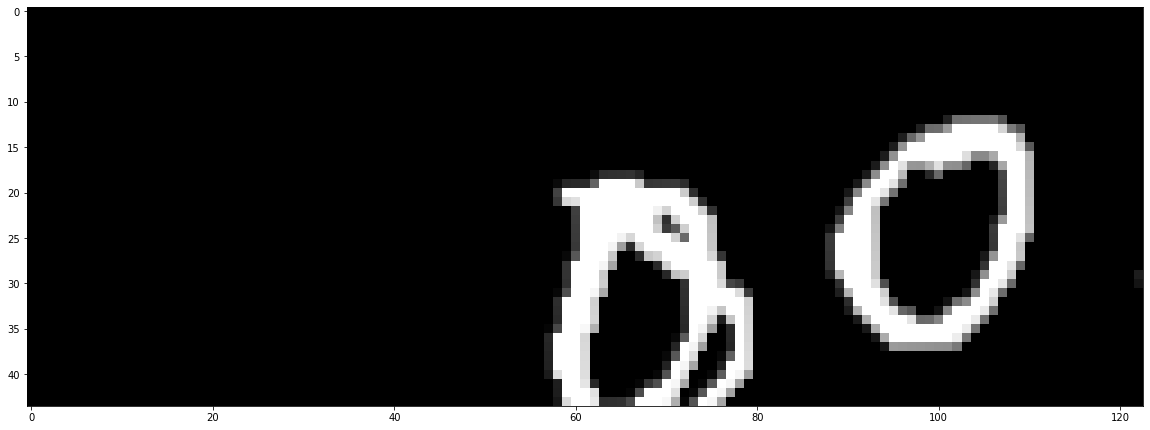

[[1, 5]]
130


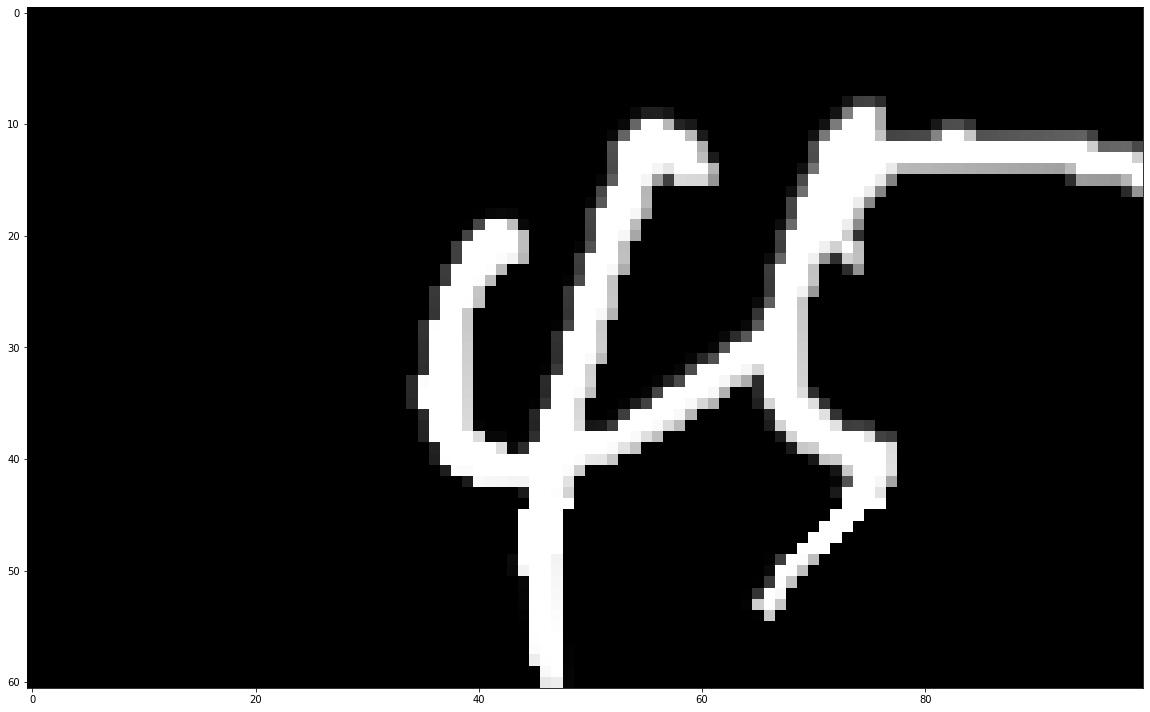

[[0]]
45


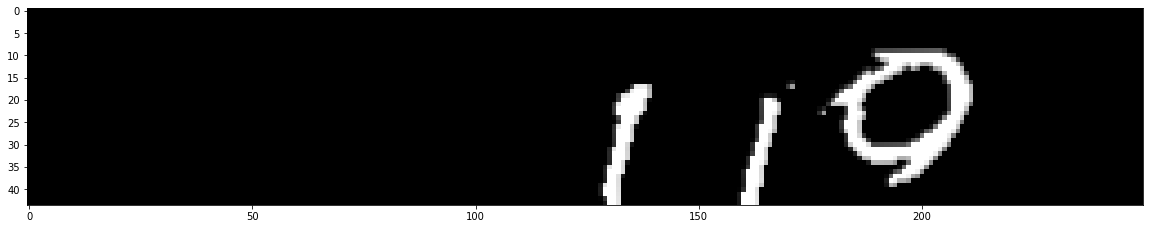

[[1], [3]]
0


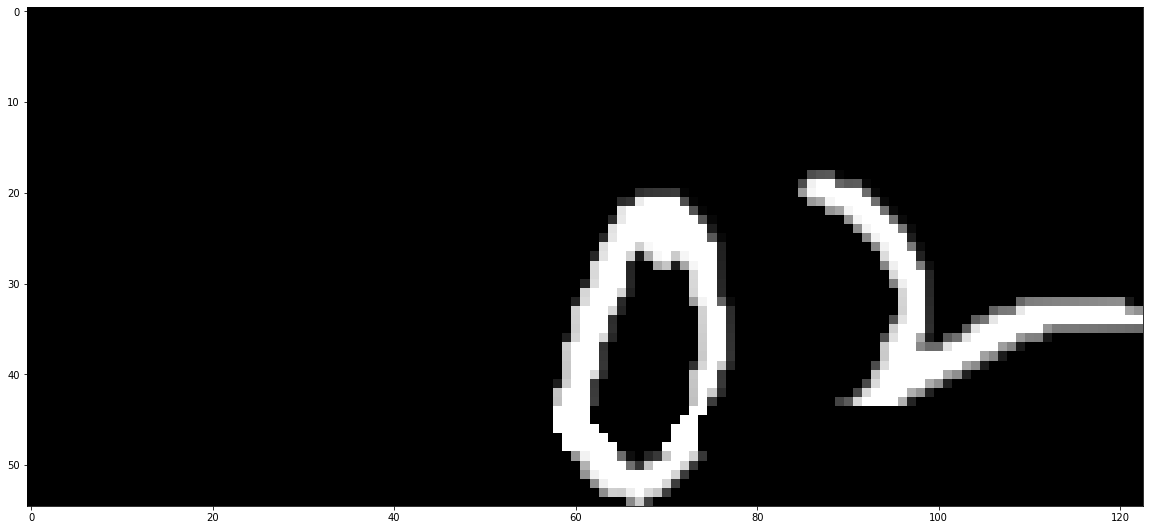

[[0, 2]]
02


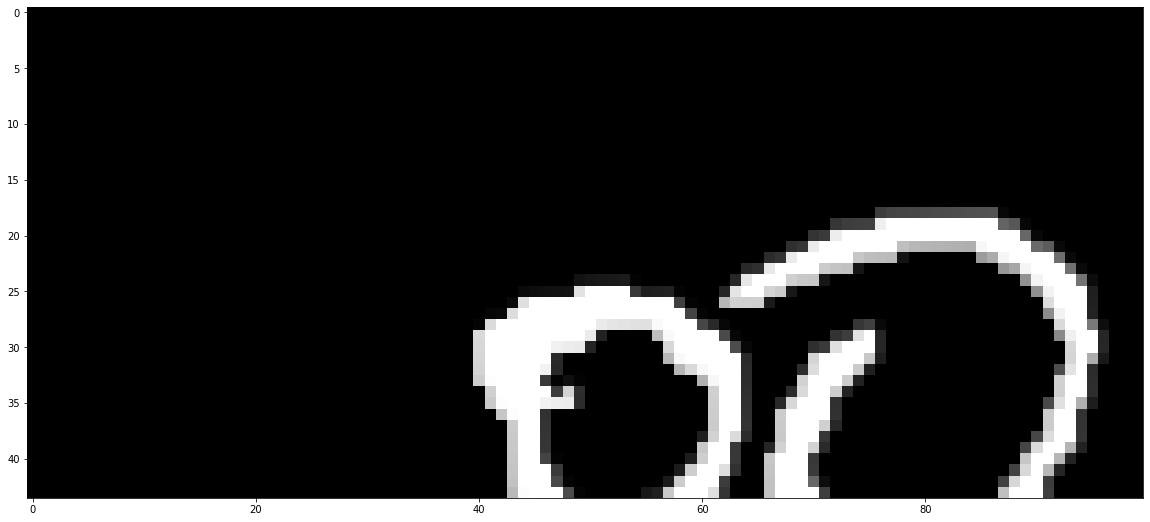

[[0, 1, 2]]
8371


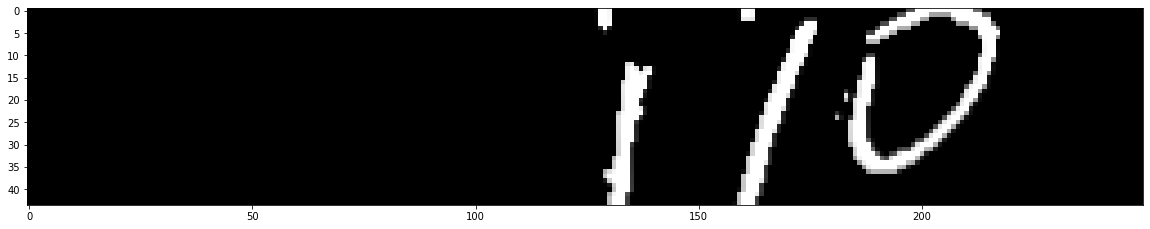

[[1, 2, 3]]
110


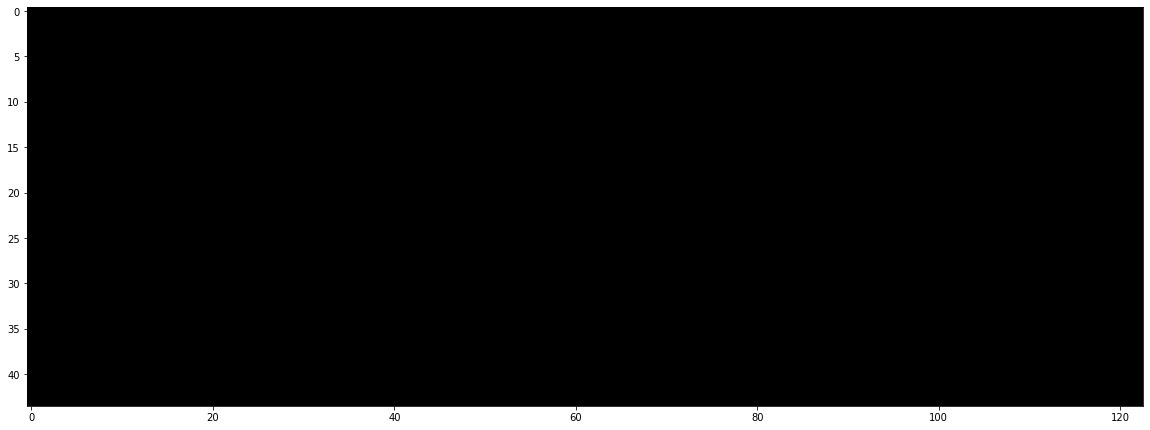

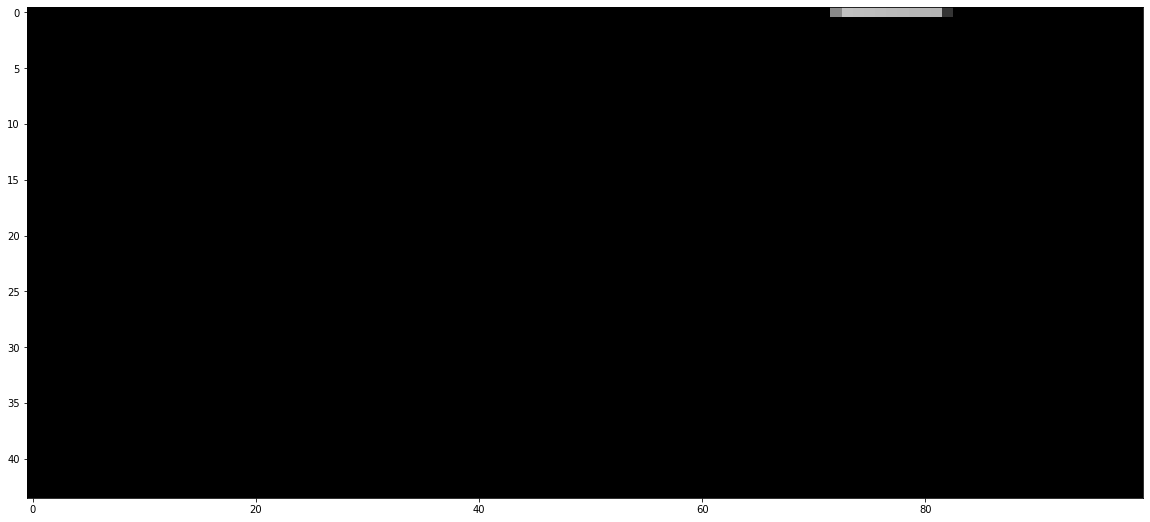

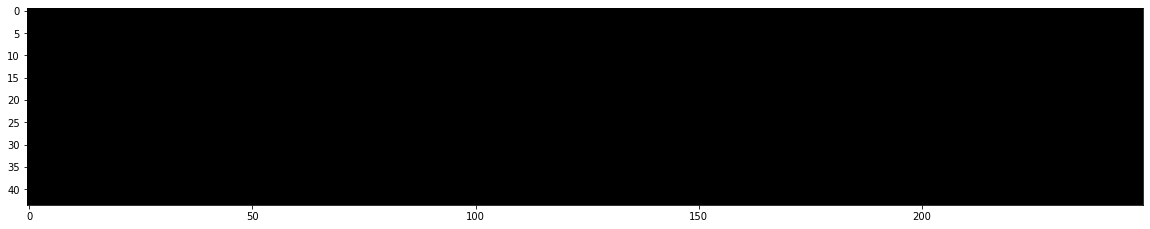

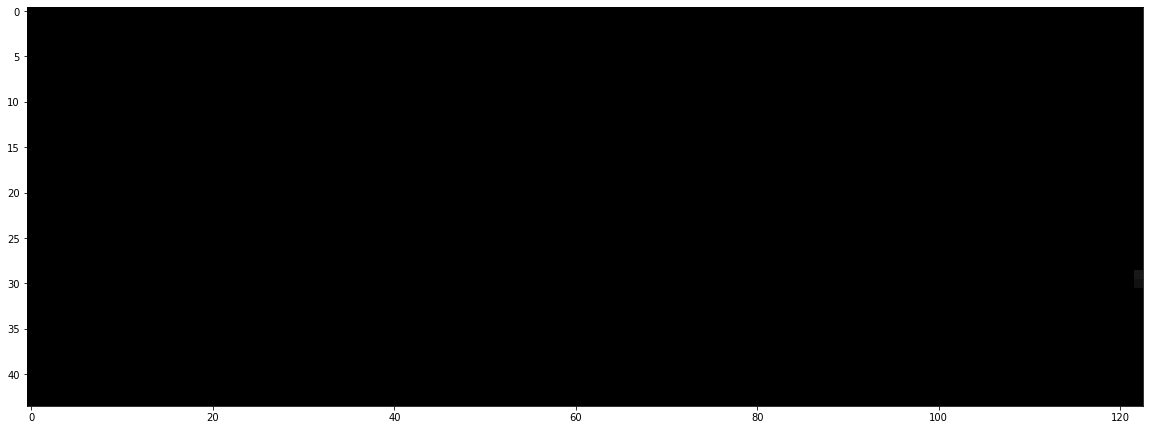

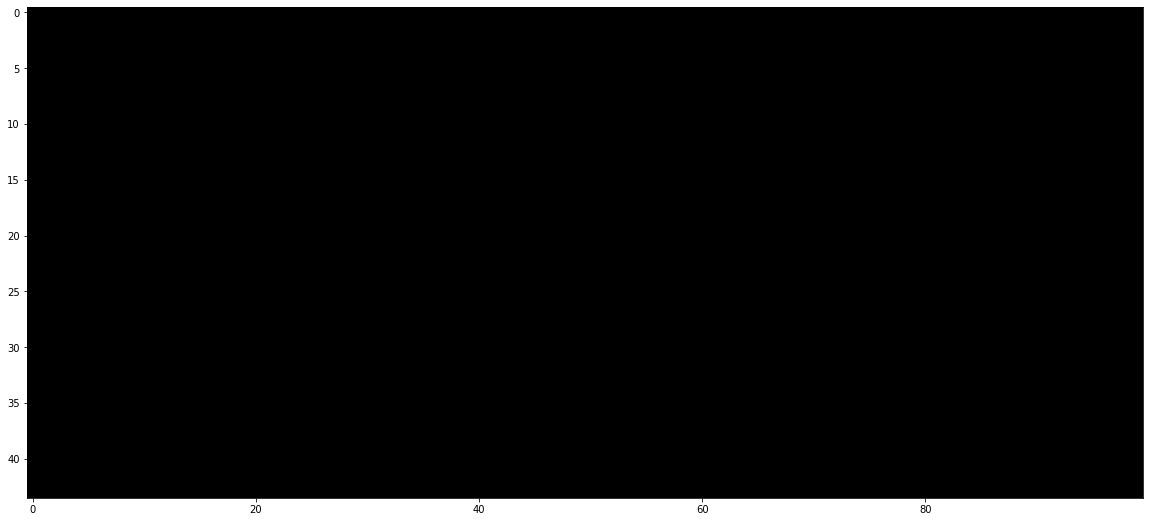

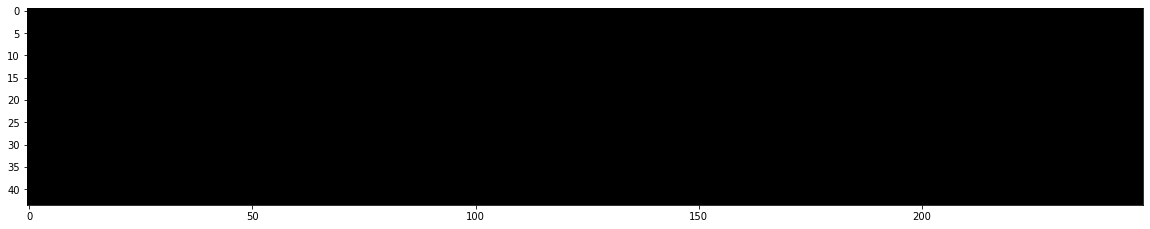

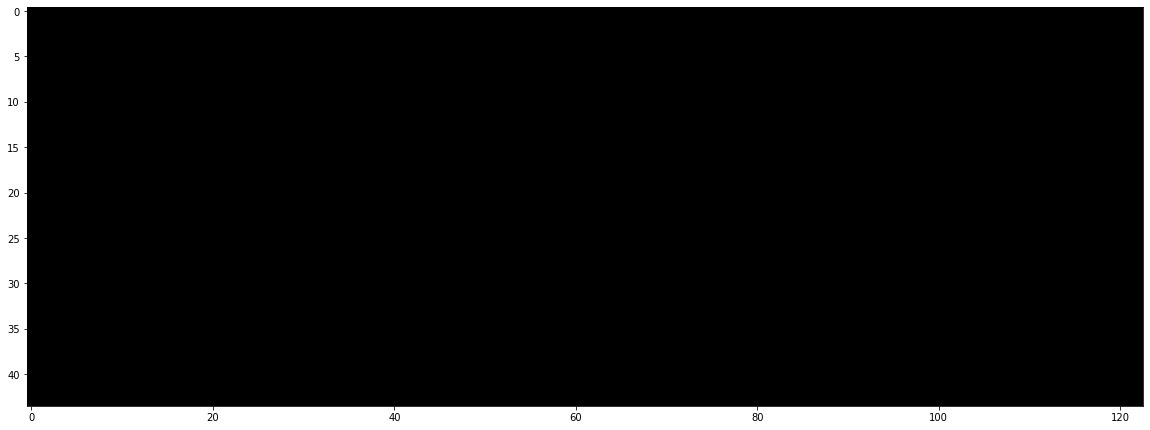

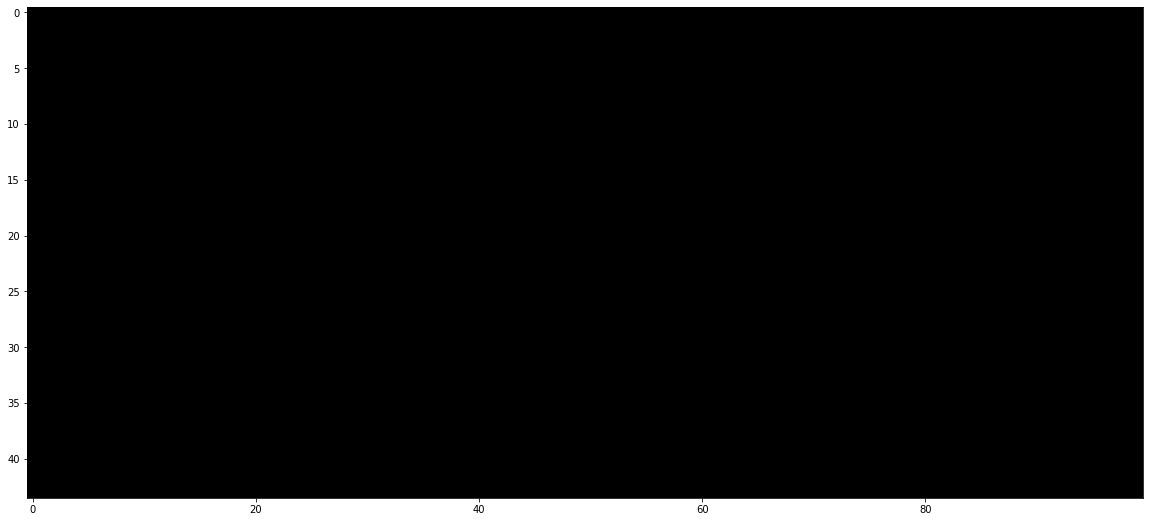

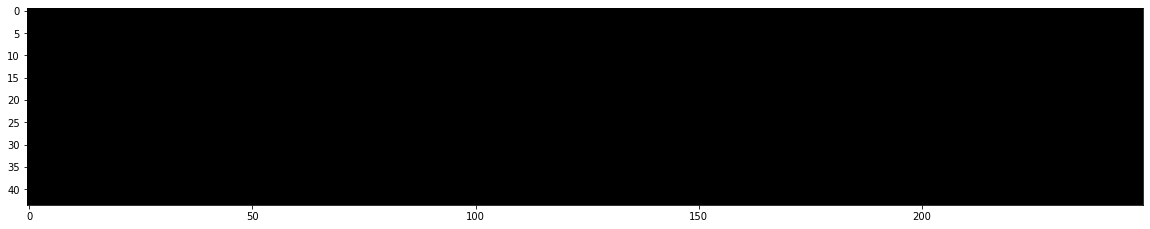

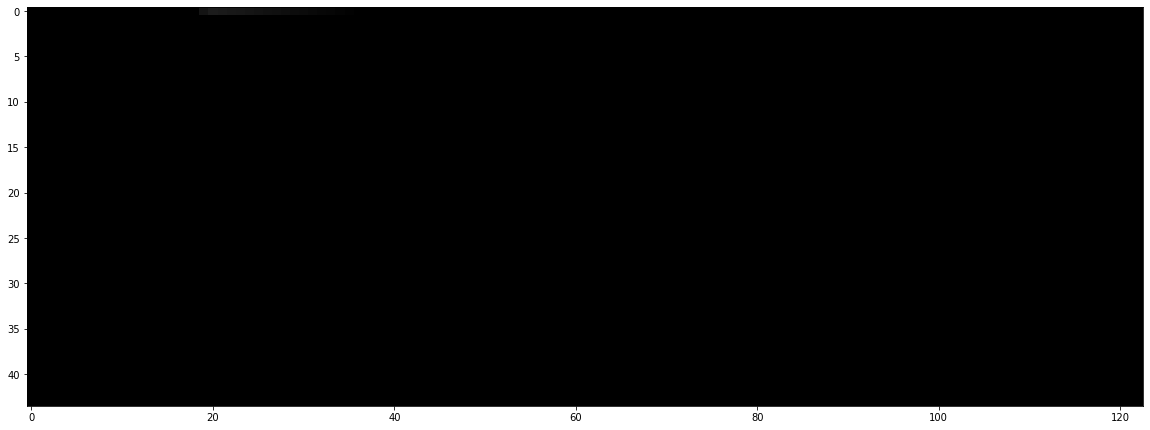

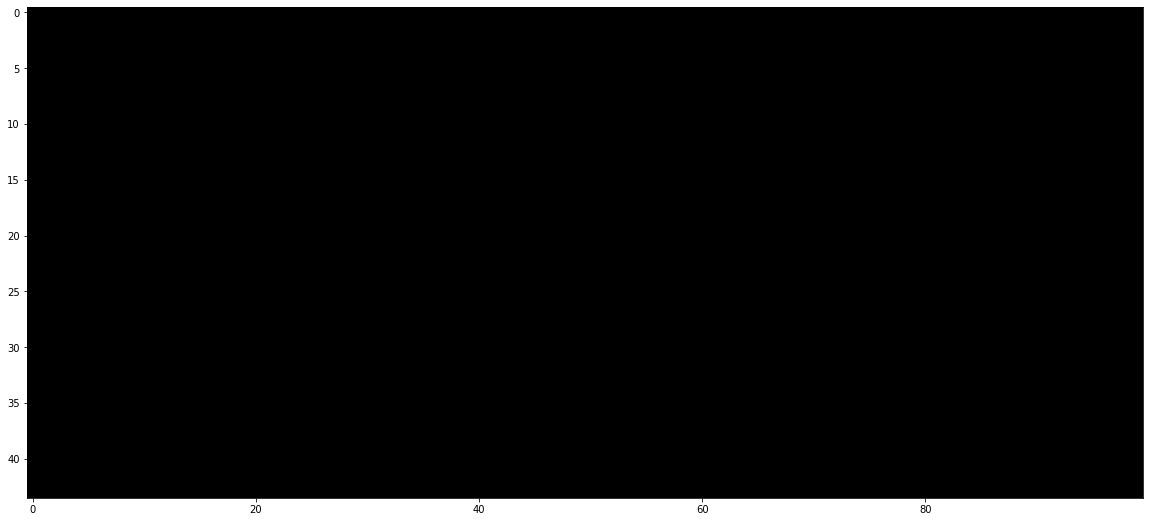

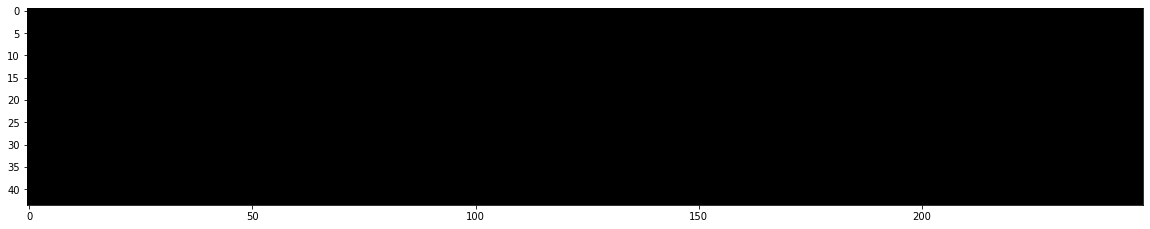

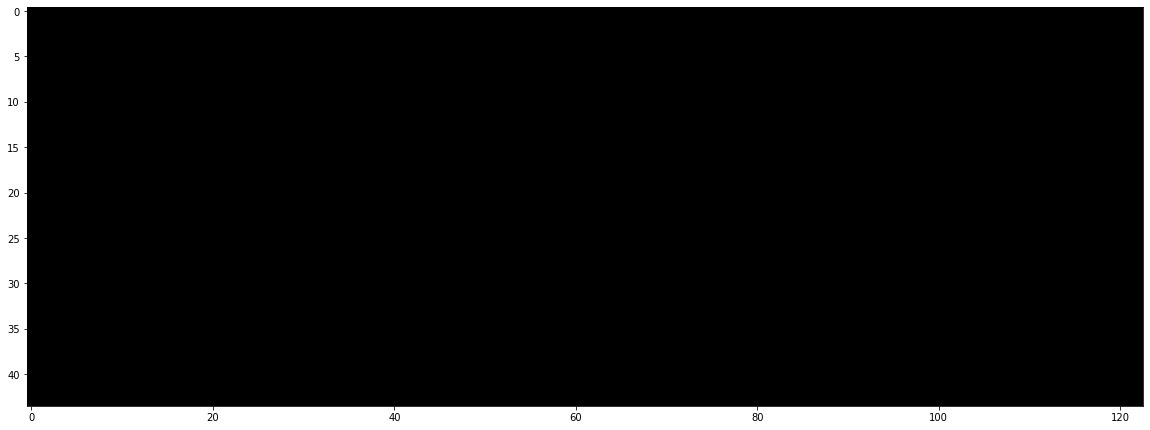

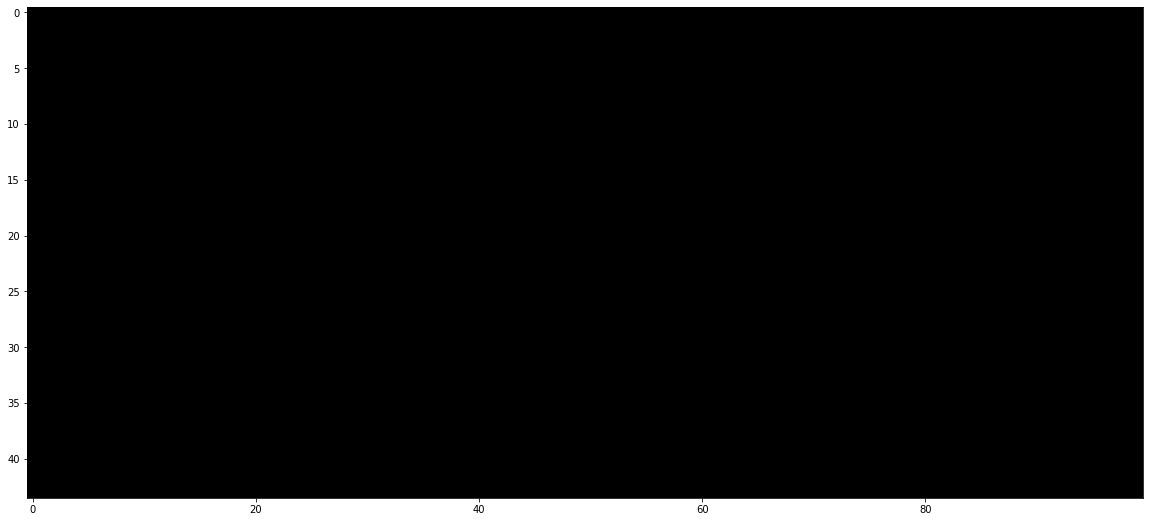

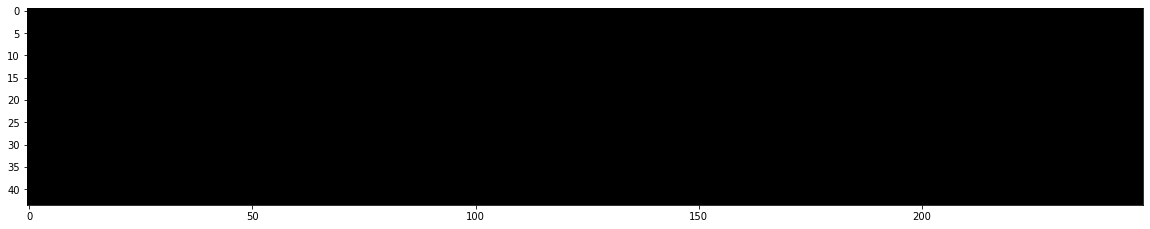

In [13]:
pi = 3.1415926535897932
def process(pred, num):
  _, length = pred.shape
  peak_list = list()
  for n in range(num - 1):
    targetidx = pred.max(dim=1)[1].item()
    peak_list.append(targetidx)
    for j in range(-1, 2):
      if(0 <= targetidx+j  and targetidx+j < length):
        pred[0,targetidx+j].sub_(2)
  peak_list.sort()
  return peak_list

def showimg(tensor):
  npimg   = utils.make_grid(tensor, padding=0)
  npimg = npimg.numpy()
  plt.figure(figsize=(20, 14))
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()
  
def find_contour(img):
  Img = (img * 255).type(dtype=torch.uint8)
  Img = Img.cpu().numpy().transpose(1, 2, 0)
  _,W, H = img.shape
  Img_size = W * H
  contours, hierachy = cv2.findContours(Img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  group = list()
  for n in range(len(contours)):
      area = cv2.contourArea(contours[n])
      if(area > Img_size * 0.0008  and hierachy[0,n,3] == -1):
          group.append((area, n))
  group.sort()
  if(len(group)== 0):
    print('error')
    return torch.zeros(1,28,28)
  
  for n in range(len(group)):
    x, y, w, h = cv2.boundingRect(contours[group[n][1]])
    if(n < len(group) - 1):
      img[:,y:y+h,x:x+w] = 0
  return img[:,y:y+h,x:x+w]

def findpeer(ele, L, D):
  if(ele not in D or D[ele] == True):
      return
  D[ele] = True
  L.append(ele)
  front = hierachy[0, ele, 0].item()
  back = hierachy[0, ele, 1].item()
  if(front != -1): findpeer(front, L, D)
  if(back != -1): findpeer(back, L, D)

def concat(up, down, f, t):
  _,_,width = up.shape
  _,height,_ = down.shape
  zero_tensor = torch.zeros(1,height,width)
  zero_tensor[:,:,f:t].add_(down)
  while(up[:,-1,:].sum().item() <= 0.8):        #합칠 경계선을 다듬어줌
    up = up[:,:-1,:]
  while(zero_tensor[:,0,:].sum().item() <= 0.8):#합칠 경계선을 다듬어줌
    zero_tensor = zero_tensor[:,1:,:]
  join_list = list()
  join_list2 = list()
  contin = False
  contin2 = False
  for n in range(width):
    if(up[0,-1,n].item() > 0.4):
      if(contin == True):
        join_list[-1][1] += 1
      else:
        join_list.append([n,1])
        contin = True
    else:
      contin = False
    if(zero_tensor[0,0,n].item() > 0.3):
      if(contin2 == True):
        join_list2[-1][1] += 1
      else:
        join_list2.append([n,1])
        contin2 = True
    else:
      contin2 = False
  crack = torch.zeros(1,5,width)       # 지워진 연결을 매꿀 부분
  for idx in range(len(join_list2)):
    join_list2[idx][0] +=  join_list2[idx][1] / 2
  for ele in join_list:
    mid = ele[0] + ele[1]/2 
    distance = width
    i = 0
    for idx in range(len(join_list2)):
      if(distance > abs(join_list2[idx][0] - mid)):
        distance = abs(join_list2[idx][0] - mid)
        i = idx
    if(distance > 10):continue        #두 포인트 사이가 멀면 이어주지 않음
    left = join_list2[i][0] - join_list2[i][1]/2
    right = join_list2[i][0] + join_list2[i][1]/2
    for n in range(5):
      crack[0,n,int((n * left + (5 - n) * ele[0])/5):int((
          n * right + (5 - n) * (ele[0]+ele[1]))/5)] = 1
  img = torch.cat((up,crack,zero_tensor),dim = 1)
  return img



tmp_path=directory_path + "Image/severance_base.jpg"
tmp_Img = cv2.imread(tmp_path)                      #이미지 객체 할당
tmp_Img = cv2.cvtColor(tmp_Img, cv2.COLOR_BGR2GRAY)     #컬러 이미지를 흑백으로 변환
tmp_Img = cv2.GaussianBlur(tmp_Img,(11,11),0)
#가우시안 블러를 통해 이미지를 부드럽게 만듦 + 숫자가 굵어지는 효과
ret,tmp_Img = cv2.threshold(tmp_Img,0,255,cv2.THRESH_OTSU) #OTSU를 통해 노이즈 제거
if(tmp_Img.mean() > 127):
    ret,tmp_Img = cv2.threshold(tmp_Img,0,255,cv2.THRESH_BINARY_INV)
    #Binary thresholding 이후 색상값 반전

tmp_Img = ToTensor()(tmp_Img)

tmp_Img = transforms.ToPILImage()(tmp_Img).convert("RGB")
tmp_Img = transforms.functional.rotate(tmp_Img, 90 - 89.578996, resample=Image.BILINEAR, expand=True, center=None)
tmp_Img = transforms.Grayscale(num_output_channels=1)(tmp_Img)
tmp_Img = ToTensor()(tmp_Img)

tmp_Img = find_contour(tmp_Img)
_, tmp_H, tmp_W = tmp_Img.shape

img_path=directory_path + "severance_data1.jpg"         #이미지 파일 주소 할당
Img = cv2.imread(img_path)                      #이미지 객체 할당
Img = cv2.cvtColor(Img, cv2.COLOR_BGR2GRAY)     #컬러 이미지를 흑백으로 변환
Img = cv2.GaussianBlur(Img,(3,3),0)
#가우시안 블러를 통해 이미지를 부드럽게 만듦 + 숫자가 굵어지는 효과
ret,Img = cv2.threshold(Img,0,255,cv2.THRESH_OTSU) #OTSU를 통해 노이즈 제거
if(Img.mean() > 127):
    ret,Img = cv2.threshold(Img,0,255,cv2.THRESH_BINARY_INV)
    #Binary thresholding 이후 색상값 반전
H, W = Img.shape
Img = ToTensor()(Img)
center_Img = find_contour(Img)                   #중앙의 숫자가 기록된 영역 추출

for i in range(H//30):         #왼쪽 위의 모서리 위치 추출
  for j in range(i+1):
    x_coord = j
    y_coord = i - x_coord
    if(center_Img[0,y_coord,x_coord].item() > 0.5):
      top_left = (y_coord, x_coord)
      break;
  if(center_Img[0,y_coord,x_coord].item() > 0.5):break
for i in range(H//30):          #왼쪽 아래 모서리 위치 추출
  for j in range(i+1):
    x_coord = j
    y_coord = -1 * (i - x_coord + 1)
    if(center_Img[0,y_coord,x_coord].item() > 0.5):
      bottom_left = (y_coord, x_coord)
      break;
  if(center_Img[0,y_coord,x_coord].item() > 0.5):break

_,height,_ = center_Img.shape
angle = 90 - math.atan2(height + bottom_left[0] - top_left[0],top_left[1] - bottom_left[1])*180/pi
center_Img2 = transforms.ToPILImage()(center_Img).convert("RGB")
center_Img2 = transforms.functional.rotate(center_Img2, angle, resample=Image.BILINEAR, expand=True, center=None)
center_Img2 = transforms.Grayscale(num_output_channels=1)(center_Img2)
center_Img2 = ToTensor()(center_Img2)
center_Img2 = find_contour(center_Img2)
center_Img2 = F.interpolate(center_Img2.unsqueeze(0), size=(tmp_H, tmp_W), mode='nearest').squeeze(0)


processed_img = center_Img2#torch.clamp(center_Img2 - tmp_Img,0,1)

image_list = list()

image_list.append(processed_img[:,6:54,640:729])
image_list.append(processed_img[:,6:54,763:860])
image_list.append(processed_img[:,6:53,890:978])
image_list.append(processed_img[:,58:106,625:725])
image_list.append(processed_img[:,58:106,755:855])
image_list.append(processed_img[:,110:155,610:725])
image_list.append(processed_img[:,109:155,775:860])
for n in range(24):
  y_up = round(268 + 51.65 * n)
  y_down = round(313 + 51.6 * n)
  image_list.append(processed_img[:,y_up:y_down,10:133])
  image_list.append(processed_img[:,y_up:y_down,160:260])
  image_list.append(processed_img[:,y_up:y_down,500:750])

showimg(tmp_Img)
showimg(processed_img)


for sample_idx in range(len(image_list)):
  #showimg(image_list[sample_idx])
  Img = image_list[sample_idx]
  _,H, W = Img.shape
  Img = (Img * 255).type(dtype=torch.uint8)
  Img = Img.cpu().numpy().transpose(1, 2, 0)
  Img_size = W * H

  contours, hierachy = cv2.findContours(Img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  Img = ToTensor()(Img)
  di = dict() #key: 특정 크기 이상의 컨투어의 인덱스 value: 탐색이 진행되었는지
  for n in range(len(contours)):
      area = cv2.contourArea(contours[n])
      if(area > Img_size * 0.001 and area < Img_size * 0.8):
          #print(area, n)
          if(hierachy[0,n,3] == -1):di[n] = False
  group = list()
    
  for key in di:
      if(di[key] == True):
          continue
      L = list()
      group.append(L)
      findpeer(key, L, di)

  group.sort(key=len)
  if(len(group)== 0):continue
  print(group)

  x_min = W
  y_min = H
  x_max = 0
  y_max = 0 
  pos_list = list()
  for idx in group[len(group)-1]:
      x, y, w, h = cv2.boundingRect(contours[idx])
      if(y + h < H//2):               #윤곽의 범위가 이미지 크기의 반도 안될 경우
        pos_list.append((x,y,w,h))    #위쪽의 이미지에 잘라서 전달해줌
        x_min = min(x_min, x)
        y_min = min(y_min, y)
        x_max = max(x_max, x+w)
        y_max = max(y_max, y+h) 
  if(len(pos_list) != 0):
    temp_input = torch.zeros(1,y_max-y_min,x_max-x_min)
  for pos in pos_list:
    temp_input[:,pos[1]-y_min:pos[1]+pos[3]-y_min,pos[0]-x_min:pos[0]+pos[2]-x_min].add_(
        image_list[sample_idx][:,pos[1]:pos[1]+pos[3],pos[0]:pos[0]+pos[2]])  
    image_list[sample_idx][0,pos[1]:pos[1]+pos[3],pos[0]:pos[0]+pos[2]] = 0
  if(sample_idx > 9 and len(pos_list) != 0):    
    image_list[sample_idx - 3] = concat(image_list[sample_idx - 3],temp_input,x_min,x_max)

for sample in image_list:
  showimg(sample)
  Img = sample
  _,W, H = Img.shape
  Img = (Img * 255).type(dtype=torch.uint8)
  Img = Img.cpu().numpy().transpose(1, 2, 0)
  Img_size = W * H

  contours, hierachy = cv2.findContours(Img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  Img = ToTensor()(Img)

  di = dict() #key: 특정 크기 이상의 컨투어의 인덱스 value: 탐색이 진행되었는지
  for n in range(len(contours)):
      area = cv2.contourArea(contours[n])
      if(area > Img_size * 0.01 and area < Img_size * 0.8):
          #print(area, n)
          if(hierachy[0,n,3] == -1):di[n] = False
  group = list()
    
  for key in di:
      if(di[key] == True):
          continue
      L = list()
      group.append(L)
      findpeer(key, L, di)

  group.sort(key=len)
  Imgs = list()

  if(len(group)== 0):
    print()
    continue
  print(group)

  for idx in group[len(group)-1]:
      x, y, w, h = cv2.boundingRect(contours[idx])
      empty_image = torch.zeros(1,h,w)
      empty_image.add_(Img[:, y:y+h, x:x+w])
      Imgs.append((x,empty_image,h/w))
  Imgs.sort()


  res = ''
  for n in range(len(Imgs)):          #각 숫자의 이미지를 담은 리스트에서 이미지 추출
      Img = Imgs[n][1]
      Img = find_contour(Img).unsqueeze(0)
      Img = F.interpolate(Img, size=(224,224), mode='nearest').to(DEVICE) #18 x 18 크기로 이미지 사이즈 조절
      digit_count = count_model(Img).max(1, keepdim=True)[1].item() + 1
      cut_point = F.softmax(slice_model(Img))
      peak_list = process(cut_point, digit_count)
      sliced_img = list()
      cutting_from = 0
      peak_list.append(19)
      Img = F.interpolate(Img, size=(round(224*Imgs[n][2]),224), mode='nearest').to(DEVICE)
      for ele in peak_list:
          cutting_to = round(ele * 224 / 19)
          centre = (cutting_from + cutting_to )//2
          r = round((cutting_to - cutting_from)*0.98/2)
          sliced_img.append(find_contour(Img[:,:,:,centre - r:centre + r].squeeze(0)).unsqueeze(0))
          cutting_from = cutting_to
      for ele in sliced_img:  
          padsize = 30
          _,_,y_length, x_length = ele.shape
          Zeros = torch.zeros(1,1,224,224)                                    #224x224 크기의 빈 이미지 생성
          if(y_length >= x_length):
            width = (224-2 * padsize)*x_length//y_length // 2
            ele =  F.interpolate(ele, size=(224-2 * padsize, width * 2), mode='nearest')
            Zeros[:,:,padsize:224-padsize,112-width :112+width].add_(ele.cpu()) #224x224 크기의 빈 이미지에 붙이기
          else:
            width = (224-2 * padsize)*y_length//x_length // 2
            ele =  F.interpolate(ele, size=(width * 2, 224-2 * padsize), mode='nearest')
            Zeros[:,:, 112-width:112+width, padsize:224-padsize].add_(ele.cpu())
          ele = Zeros
          img_transform = transforms.Compose([
                       transforms.Normalize((0.1307,),(0.3881,))
                       #MNIST 데이터셋의 평균과 표준편차                
          ])
          Img = img_transform(ele.squeeze(0)).unsqueeze(0).to(DEVICE)
          rec_model.eval()
          output = rec_model(Img)
    #CNN모델에서 숫자를 인식한 뒤 softmax된 output 받음
          pred = output.max(1, keepdim=True)[1].item()
    #가장 확률이 높은 인덱스를 예측값으로 받음
          res += str(pred)
  print(res)